# Simulation of electron-nuclear spin dynamics

This notebook allows to simulate the dynamics of a $Er^{3+}$ electron spin ($S = 1/2$) with a $^{183}W$ ($I = 1/2$) down to the pulse level using QuTip (https://qutip.org/docs/latest/).

The exact shape of the pulse used in the simulation is determined upon the experimental relaxation rate of the MW cavity, and can be freely modified by the user to simulate any case scenario.

In [3]:
from multiprocessing import Pool, cpu_count
from src.utility import *
from src.pulses import *
from src.plotting import*

%matplotlib inline
worker_count = max(cpu_count() - 1, 1)

## Introduction

The system considered is a tensor space of the electron spin S=1/2 and the nuclear spin I=1/2 subspaces.

The coupling of the intrinsic magnetic moment of the electron spin and the nuclear spin is called the hyperfine interaction. Since the magnetic moment of the electron spin is much larger than that of the nuclear spin, the electron strongly influences the dynamics of the surrounding nuclear spins. As a consequence, electrons can be used to manipulate them (see the figure below).

Here, flipping the electron spin (by applying a $\pi$ pulse) changes the quantization axis $\mathbf{m_{\uparrow \downarrow}}$ of the surrounding $^{183}W$ nuclear spins. By choosing the right period $2 \tau$ between the $\pi$ pulses, one can selectively address a single nuclear spin and flip its state. It is upon this technique that all dynamical decoupling sequences stem from.

<img src="figs/Quantization_axis_LB_CaWO4.jpg" width="600"/>

The static spin Hamiltonian comprises the electron and nuclear Zeeman interactions ($H_{EZ}$ and $H_{NZ}$ respectively) as well as the hyperfine interaction:

$$H_0 = H_{EZ} + H_{NZ} + H_{DD}$$

In the following, we choose to express the Hamiltonian exclusively in terms of angular frequencies (i.e. $H / \hbar$ which we will write simply as $H$). Using the secular approximation, the static Hamiltonian of the system in the rotating frame may be written as:

$$H_0 = \vec{\omega_S} \cdot \vec{S} + \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

where $A$ and $B$ are the secular hyperfine coupling constants.

By applying the rotating wave approximation, we can neglect the electron Zeeman interaction so that the static Hamiltonian becomes:

$$H_0 = \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

The total Hamiltonian $H$ comprises the static Hamiltonian $H_0$ as well as the time-dependent Hamiltonian $H_t$ which is simply:

$$H_t = f(t) \sigma_z$$

where $f: t \rightarrow f(t)$ is the pulse function to apply to the electron (which depends on the sequence considered).

#### References
* [Léo Balembois. Magnetic resonance of a single electron spin and its magnetic environment by photon counting. Université Paris-Saclay, 2023.](https://theses.hal.science/tel-04165482)
* [Arthur Schweiger and Gunnar Jeschke. Principles of pulse electron paramagnetic resonance. Oxford University Press, 2001.](https://global.oup.com/academic/product/principles-of-pulse-electron-paramagnetic-resonance-9780198506348?cc=fr&lang=en&)
* [T. H. Taminiau et al. Detection and Control of Individual Nuclear Spins Using a Weakly Coupled Electron Spin. Physical Review Letters 109.137602, 2012.](https://link.aps.org/doi/10.1103/PhysRevLett.109.137602)

### Parameters
Frequencies are given in MHz and durations in $\mu s$. Therefore, the time basis will be in $\mu s$.

In [4]:
# Spin parameters
h    = 6.6260693e-34       # J.s
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.2355695           # g nuclear 183W (INDC International Nuclear Data Committee)
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T

# Magnetic field
B0 = 0.447 # T
theta = 0*np.pi/180 # rad
phi = 0*np.pi/180 # rad
B_field = np.array([B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)])

omega_L = 2*np.pi*mu_I/h*1e-6*B0 # rad/us

# Hyperfine constants
A = 2*np.pi * 1e-3 * 40  # 40 kHz
B = 2*np.pi * 1e-3 * 40 # 6.8 kHz 
eta = np.arctan(B/(2*omega_L))

### Setup of the operators and the static Hamiltonian

In [5]:
S = 1/2
nS = int(2*S+1)
(Sx,Sy,Sz) = generate_S(S)

In [6]:
I = 1/2
nI = int(2*I+1)
(Ix,Iy,Iz) = generate_S(I)

In [7]:
# Local oscillator at 10 MHz
omega_LO = 2*np.pi*0
H_LO = tensor(omega_LO*Sz, qeye(nI))

# Nuclear Zeeman interaction
omega_Ix = 2*np.pi*mu_I/h*1e-6*B_field[0]
omega_Iy = 2*np.pi*mu_I/h*1e-6*B_field[1]
omega_Iz = 2*np.pi*mu_I/h*1e-6*B_field[2]
H_NZ = tensor(qeye(nS), omega_Ix*Ix + omega_Iy*Iy + omega_Iz*Iz)

# Electron-nuclear dipole-dipole interaction (hyperfine)
H_DD = A*tensor(Sz,Iz) + B*tensor(Sz,Ix) + B*tensor(Sz,Iy)

# Total static Hamiltonian
H0 = H_LO + H_NZ + H_DD

In [8]:
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 2.5844496 +0.j          0.06283185-0.06283185j  0.        +0.j
   0.        +0.j        ]
 [ 0.06283185+0.06283185j -2.5844496 +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          2.45878589+0.j
  -0.06283185+0.06283185j]
 [ 0.        +0.j          0.        +0.j         -0.06283185-0.06283185j
  -2.45878589+0.j        ]]

array([-411.57097229, -391.58338584,  391.58338584,  411.57097229])

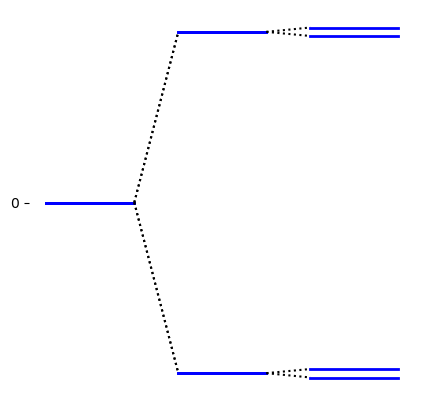

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
visualization.plot_energy_levels([H_LO/(2*np.pi*1e-3), H_NZ/(2*np.pi*1e-3), H_DD/(2*np.pi*1e-3)], 4, show_ylabels=True, ax=ax)
H0.eigenstates()[0]/(2*np.pi*1e-3) # Eigenenergies in kHz

In [10]:
H0.eigenstates()[1][0]

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.01215037+0.01215037j]
 [ 0.99985236+0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]

# Pi pulse definition

/Users/jaime/miniconda3/envs/lab-env/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


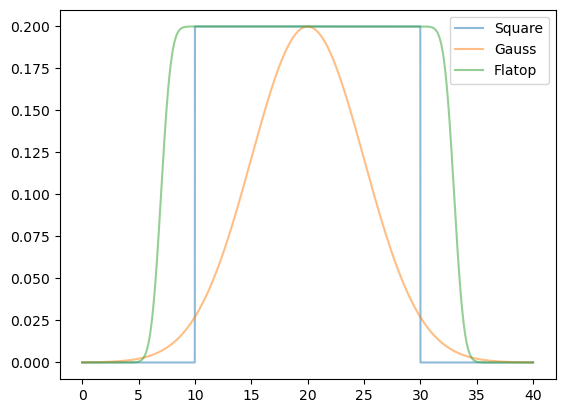

In [11]:
from scipy.special import erf
from cmath import exp

def ErfRising(t, sigma, amplitude, t0):
    return amplitude * (erf((t - t0) / sigma) + 1) / 2


def square_pulse(t, args):
    pulse_duration = args['pulse_duration']
    amplitude = args['amplitude']
    t0 = args['t0']
    if t > (t0 - pulse_duration/2) and t < (t0 + pulse_duration/2):
        return amplitude 
    else:
        return 0
def square_pulse_p(t, args): return square_pulse(t, args) * np.exp(+1j*((args['detuning']+omega_LO)*t + args['phase']))
def square_pulse_m(t, args): return square_pulse(t, args) * np.exp(-1j*((args['detuning']+omega_LO)*t + args['phase']))

        
def gaussian_pulse(t, args):
    sigma = args['sigma_gauss']
    amplitude = args['amplitude']
    t0 = args['t0']
    if t > (t0-sigma) and t < (t0+sigma):
        return amplitude * np.exp(-((t - t0) ** 2) / (2 * (sigma/6) ** 2))
    else: 
        return 0
def gaussian_pulse_p(t, args): return gaussian_pulse(t, args) * np.exp(+1j*((args['detuning']+omega_LO)*t + args['phase']))
def gaussian_pulse_m(t, args): return gaussian_pulse(t, args) * np.exp(-1j*((args['detuning']+omega_LO)*t + args['phase']))



def flattop_pulse(t, args):
    pulse_duration = args['pulse_duration']
    sigma = args['sigma_raise']
    amplitude = args['amplitude']
    t0 = args['t0']
    if t > (t0 - pulse_duration/2 - 6*sigma) and t < (t0 - pulse_duration/2):
        return ErfRising(t, sigma, amplitude, t0 - pulse_duration/2 - 3*sigma) 
    elif t > (t0 - pulse_duration/2) and t < (t0 + pulse_duration/2):
        return amplitude 
    elif t > (t0 + pulse_duration/2) and t < (t0 + pulse_duration/2 + 6*sigma):
        return (amplitude-ErfRising(t, sigma, amplitude, t0 + pulse_duration/2 + 3*sigma))
    else:
        return 0
def flattop_pulse_p(t, args): return flattop_pulse(t, args) * np.exp(+1j*((args['detuning']+omega_LO)*t + args['phase']))
def flattop_pulse_m(t, args): return flattop_pulse(t, args) * np.exp(-1j*((args['detuning']+omega_LO)*t + args['phase']))

    

args = {
    'sigma_raise': 1,
    'sigma_gauss': 30,
    'pulse_duration': 20,
    'amplitude': 0.2,
    't0': 20,
    'detuning': 0,
    'phase': 0,
}

t = np.linspace(0, 40, 5000)
p = [square_pulse_p(_t, args) for _t in t]
g = [gaussian_pulse(_t, args) for _t in t]
ft = [flattop_pulse(_t, args) for _t in t]
    
plt.figure()
plt.plot(t, p, alpha=0.5, label="Square")
plt.plot(t, g, alpha=0.5, label="Gauss")
plt.plot(t, ft, alpha=0.5, label="Flatop")
plt.legend()

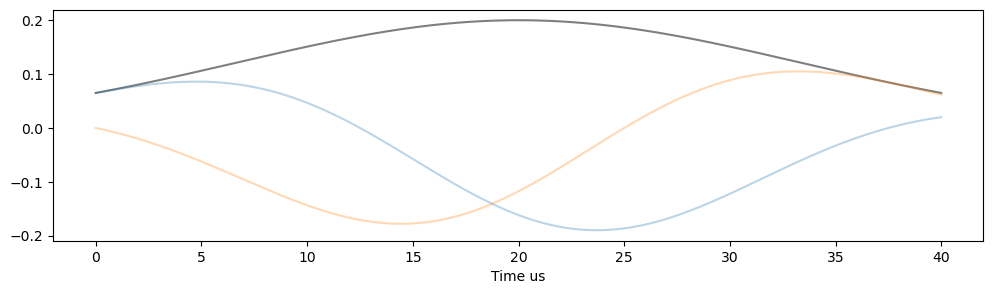

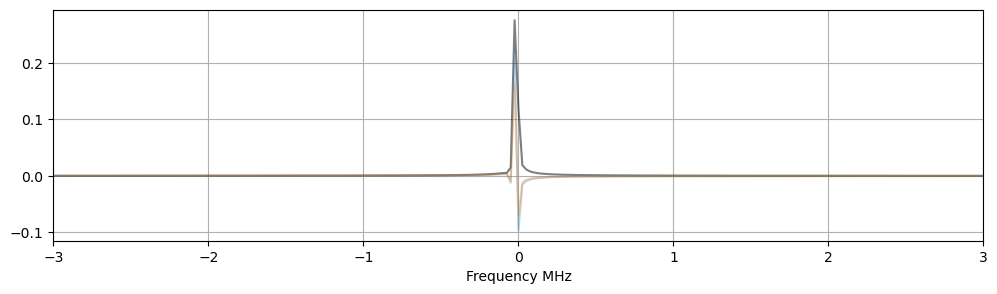

In [12]:
%matplotlib inline
from scipy.fft import fft, fftfreq, fftshift
import numpy as np

args = {
    'sigma_raise': 1,
    'sigma_gauss': 80,
    'pulse_duration': 20,
    'amplitude': 0.2,
    't0': 20,
    'detuning': A/2,
    'phase': 0,
}


# Number of sample points
N = 5000
# sample spacing
T = 40 / N
x = np.linspace(0.0, N*T, N, endpoint=False)
y = [gaussian_pulse_m(_t, args) for _t in x]
yf = fftshift(fft(y))
xf = fftshift(fftfreq(N, T))

plt.figure(figsize=(12,3))
plt.plot(x, np.abs(y), 'k', alpha=0.5)
plt.plot(x, np.real(y), alpha=0.3)
plt.plot(x, np.imag(y), alpha=0.3)
plt.xlabel("Time us")

plt.figure(figsize=(12,3))
plt.plot(xf, 2.0/N * np.abs(yf), 'k', alpha=0.5)
plt.plot(xf, 2.0/N * np.real(yf), alpha=0.3)
plt.plot(xf, 2.0/N * np.imag(yf), alpha=0.3)
plt.xlim([-3, 3])
plt.xlabel("Frequency MHz")
plt.grid()
plt.show()

# Arbitrary pulse sequence

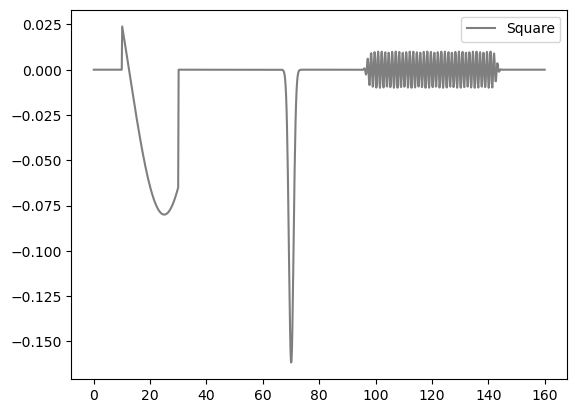

In [13]:
pulse_map_p = {
    "s": square_pulse_p,
    "g": gaussian_pulse_p,
    "ft": flattop_pulse_p
}

pulse_map_m = {
    "s": square_pulse_m,
    "g": gaussian_pulse_m,
    "ft": flattop_pulse_m
}

def pulse_sequence_p(t, args):
    """
    Generate an arbitrary pulse sequence based on the argument dictionary using the Qutip notation

    Input:
        - t (float): time in microseconds
        - args (dict): dictionary with two elements:
            -- pulses: (list): list of strings that can be "s", "g" or "ft" refering to either square, gauss or flattop pulse.
            -- args_pulses: (list): list of same length as pulses that contains the arguments for the corresponding pulse.

    Outputs:
        - H (array): hamiltonian in the style of Qutip
    
    """
    H = 0+0j
    for pulse, args_pulse in zip(args["pulses"], args["args_pulses"]):
        try: pulse_fnc = pulse_map_p[pulse]
        except KeyError: raise KeyError("The only accepted pulse types are 's', 'g' or 'ft'")
        H += pulse_fnc(t, args_pulse)
    return H

def pulse_sequence_m(t, args):
    H = 0+0j
    for pulse, args_pulse in zip(args["pulses"], args["args_pulses"]):
        try: pulse_fnc = pulse_map_m[pulse]
        except KeyError: raise KeyError("The only accepted pulse types are 's', 'g' or 'ft'")
        H += pulse_fnc(t, args_pulse)
    return H

pulses, args_pulses = [], []

pulses.append("s")
args_pulses.append({
    'sigma_raise': 1,
    'sigma_gauss': 5,
    'pulse_duration': 20,
    'amplitude': 0.08,
    't0': 20,
    'detuning': A/2,
    'phase': 0,
})

pulses.append("g")
args_pulses.append({
    'sigma_raise': 1,
    'sigma_gauss': 5,
    'pulse_duration': 20,
    'amplitude': 0.2,
    't0': 70,
    'detuning': A/2,
    'phase': 0,
})

pulses.append("ft")
args_pulses.append({
    'sigma_raise': 1,
    'sigma_gauss': 5,
    'pulse_duration': 40,
    'amplitude': 0.01,
    't0': 120,
    'detuning': omega_L,
    'phase': 0,
})

seq_args = {"pulses": pulses, "args_pulses": args_pulses}

t = np.linspace(0, 160, 1000)
p = [pulse_sequence_p(_t, seq_args) for _t in t]
    
plt.figure()
plt.plot(t, p, 'k', alpha=0.5, label="Square")
plt.legend()

# Electron transition

## Detuning measurement

In [14]:
sigmam()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]

Text(0, 0.5, '$<S_z>$')

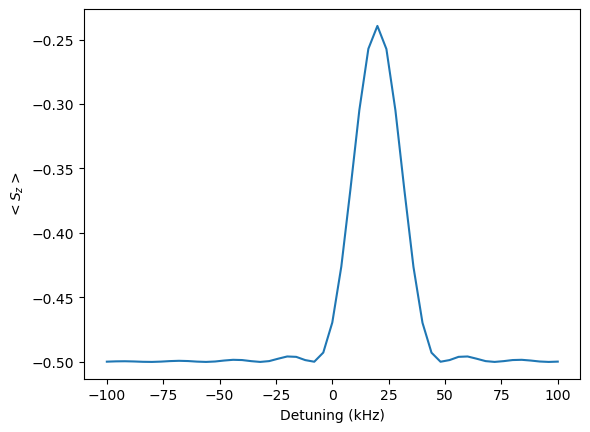

In [15]:
%matplotlib inline
ket0 = H0.eigenstates()[1][1] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

t = np.linspace(0, 40, 100)
H_square_p = [tensor(sigmap(),qeye(nI)), gaussian_pulse_p]
H_square_m = [tensor(sigmam(),qeye(nI)), gaussian_pulse_m]

n_points = 51
detuning = A/2*np.linspace(-5, 5, n_points)

plot = False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

rab = []
for ii, det in enumerate(detuning):
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 100,
        'pulse_duration': 3,
        'amplitude': 1/60,
        't0': 20,
        'detuning': det, # 2pi*f in MHz
        'phase': 0
    }
    
    result = mesolve([H0, H_square_p, H_square_m], ket0, t, [], [], args=args)
    rab.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    if plot:
        ax[ii].plot(t, expect(tensor(Sz, qeye(nI)), result.states), label="Detuning = %.2f kHz"%(det/2/np.pi*1e3))
        ax[ii].plot(t, [square_pulse(_t, args) for _t in t], alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

plt.figure()
plt.plot(detuning/2/np.pi*1e3, rab)
plt.xlabel("Detuning (kHz)")
plt.ylabel(r'$<S_z>$')

[0.02, 0.04, 0.2605624312719062, -0.49999984917659024]


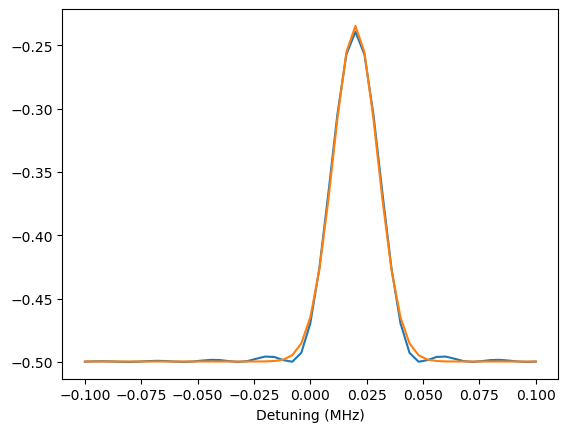

In [16]:
def gaussian_fit(x, x0, sigma, a, b):
    return a * np.exp(-((x-x0)/(2*sigma))**2) + b

def sinc_fit(x, x0, sigma, a, b):
    return a * np.sinc((x-x0)/sigma) + b

x = detuning/2/np.pi
guess = [x[np.argmax(rab)], (x[-1]-x[0])/5, np.max(rab)-np.min(rab), np.min(rab)]
popt, pcov = curve_fit(gaussian_fit, x, rab, guess)

plt.figure()
plt.plot(x, rab)
plt.plot(x, gaussian_fit(x, *popt))
plt.xlabel("Detuning (MHz)")
print(guess)

## Rabi all pulses

In [17]:
(H0.eigenstates()[0][0] - H0.eigenstates()[0][2]) / omega_L

-1.0006210631767025

In [18]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_square_p = [tensor(sigmap(),qeye(nI)), square_pulse_p]
H_square_m = [tensor(sigmam(),qeye(nI)), square_pulse_m]

H_gaussian_p = [tensor(sigmap(),qeye(nI)), gaussian_pulse_p]
H_gaussian_m = [tensor(sigmam(),qeye(nI)), gaussian_pulse_m]

H_flattop_p = [tensor(sigmap(),qeye(nI)), flattop_pulse_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), flattop_pulse_m]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

n_points = 30
amplitudes = np.linspace(0, 0.2, n_points)

plot=False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

# Simulation

t = np.linspace(0, 40, 500)
sz_square = []
sz_gaussian = []
sz_falttop = []
for ii, amp in enumerate(amplitudes):
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 30,
        'pulse_duration': 30,
        'amplitude': amp,
        't0': 20,
        'detuning': A/2, # 2pi*f in MHz
        'phase': 1,
    }

    result = mesolve([H0, H_gaussian_p, H_gaussian_m], ket0, t, [], [], args=args)
    sz_gaussian.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    
    result = mesolve([H0, H_flattop_p, H_flattop_m], ket0, t, [], [], args=args)
    sz_falttop.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    
    result = mesolve([H0, H_square_p, H_square_m], ket0, t, [], [], args=args)
    sz_square.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
        
    if plot:
        ax[ii].plot(t, expect(tensor(Sz, Iz+0.5*qeye(nI)), result.states), label="Rabi Frequency = %.2f kHz"%(amp))
        ax[ii].plot(t, expect(tensor(Sz, Iz-0.5*qeye(nI)), result.states), label="Rabi Frequency = %.2f kHz"%(amp))
        ax[ii].plot(t, [square_pulse(_t, args) for _t in t], alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

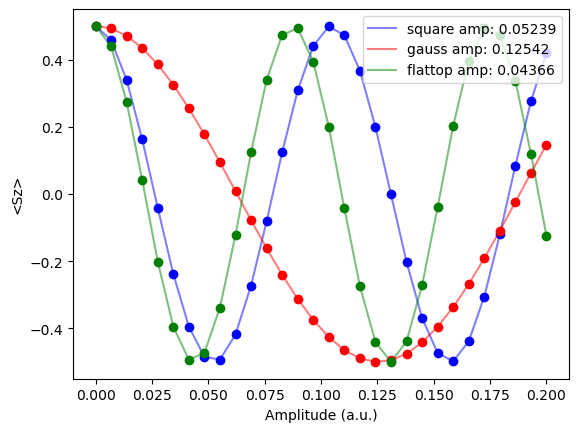

In [19]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

plt.figure()
guess = [10, 0.5, 0]
popt, pcov = curve_fit(rabi_fit, amplitudes, sz_square, guess)
plt.plot(amplitudes, sz_square, 'ob')
plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'b', alpha=0.5, label="square amp: %.5f"%(1/popt[0]/2))

guess = [3, -0.5, 0]
popt, pcov = curve_fit(rabi_fit, amplitudes, sz_gaussian, guess)
plt.plot(amplitudes, sz_gaussian, 'or')
plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'r', alpha=0.5, label="gauss amp: %.5f"%(1/popt[0]/2))

guess = [10, -0.5, 0]
popt, pcov = curve_fit(rabi_fit, amplitudes, sz_falttop, guess)
plt.plot(amplitudes, sz_falttop, 'og')
plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'g', alpha=0.5, label="flattop amp: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

## Selective excitation

In [20]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_gaussian_p = [tensor(sigmap(),qeye(nI)), gaussian_pulse_p]
H_gaussian_m = [tensor(sigmam(),qeye(nI)), gaussian_pulse_m]

ket0 = H0.eigenstates()[1][1] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
pi_amplitude = 0.125
pi_duration = 30

n_points = 10
durations = np.linspace(1, 101, n_points)
amplitudes = pi_amplitude *  pi_duration / durations

plot=False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

t = np.linspace(0, 100, 500)
sz_gaussian = []
for ii, (amp, dur) in enumerate(zip(amplitudes, durations)):
    args = {
        'sigma_raise': 1,
        'sigma_gauss': dur,
        'pulse_duration': dur,
        'amplitude': amp,
        't0': t[-1]/2,
        'detuning': -A/2, # 2pi*f in MHz
        'phase': 0
    }
    result = mesolve([H0, H_gaussian_p, H_gaussian_m], ket0, t, [], [], args=args)
    sz_gaussian.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    if plot:
        ax[ii].plot(t, expect(tensor(Sz, qeye(nI)), result.states), label="Detuning = %.2f kHz"%(det/2/np.pi*1e3))
        ax[ii].plot(t, [gaussian_pulse(_t, args) for _t in t], alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()
    

(-0.01, 1.01)

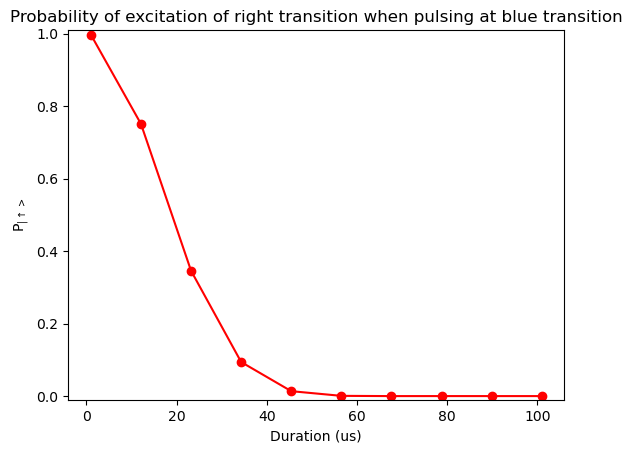

In [21]:
plt.plot(durations, 0.5+np.array(sz_gaussian), 'o-r')
plt.title("Probability of excitation of right transition when pulsing at blue transition")
plt.xlabel("Duration (us)")
plt.ylabel(r"P$_{|\uparrow>}$")
plt.ylim([-0.01, 1.01])


## Ramsey

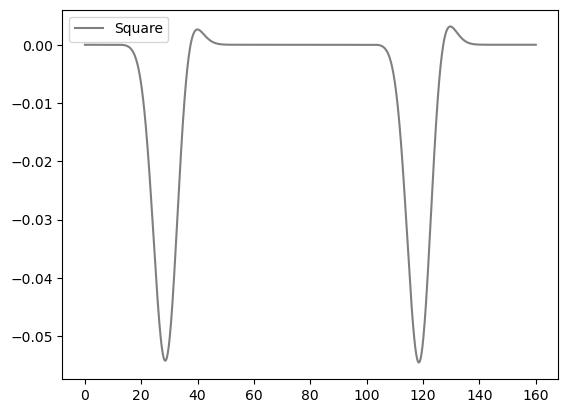

In [22]:
pulses, args_pulses = [], []

pulses.append("g")
args_pulses.append({
    'sigma_gauss': 30,
    'amplitude': 0.12534/2,
    't0': 30,
    'detuning': A/2,
    'phase': 0,
})

pulses.append("g")
args_pulses.append({
    'sigma_gauss': 30,
    'amplitude': 0.12534/2,
    't0': 120,
    'detuning': A/2 * 1.05,
    'phase': 0.5,
})

seq_args = {"pulses": pulses, "args_pulses": args_pulses}

t = np.linspace(0, 160, 1000)
p = [pulse_sequence_p(_t, seq_args) for _t in t]
    
plt.figure()
plt.plot(t, p, 'k', alpha=0.5, label="Square")
plt.legend()

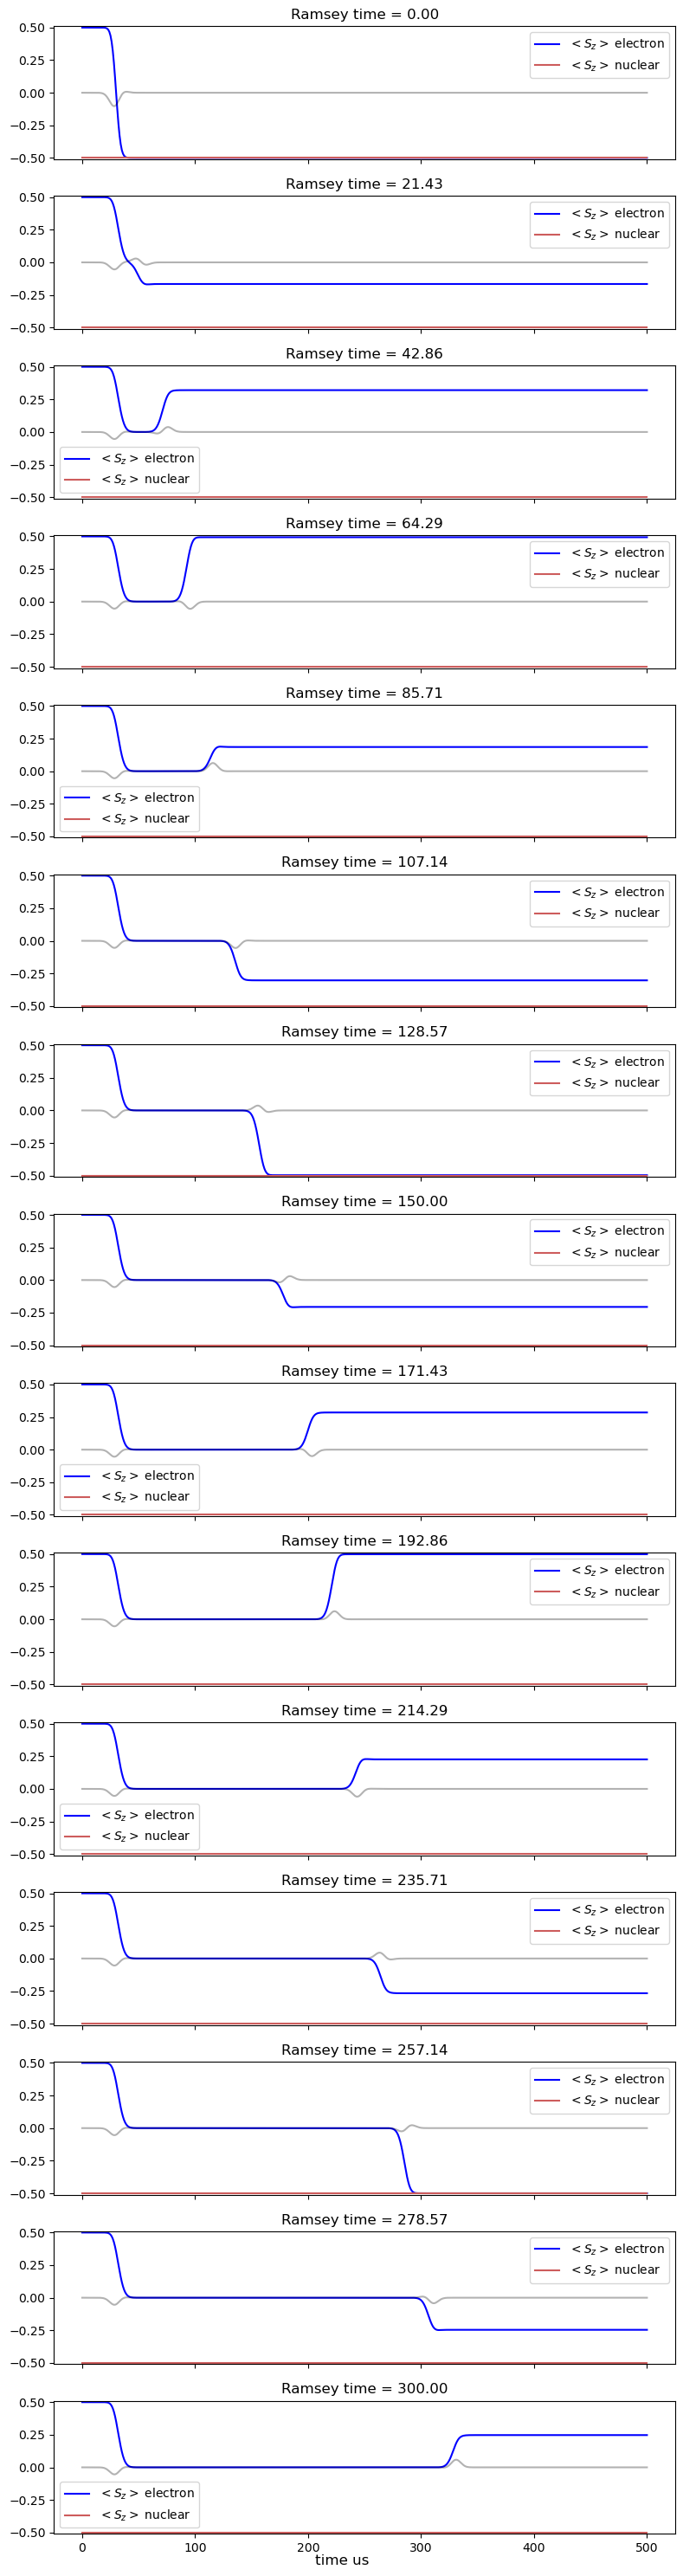

In [132]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop_p = [tensor(sigmap(),qeye(nI)), pulse_sequence_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), pulse_sequence_m]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 15
ramsey_times = np.linspace(0, 300, n_points)
ramsey_detuning = 2*np.pi/(ramsey_times[-1] - ramsey_times[0]) * 2 

plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, r_time in enumerate(ramsey_times):
    seq_args["args_pulses"][1]["t0"] = 30 + r_time
    seq_args["args_pulses"][1]["phase"] = r_time * ramsey_detuning
    t = np.linspace(0, 500, 500)
    result = mesolve([H0, H_flattop_p, H_flattop_m], ket0, t, [], [], args=seq_args)

    res_e = expect(tensor(Sz, qeye(nI)), result.states)
    res_n = expect(tensor(qeye(nS), Sz), result.states)

    sz_electron.append(res_e[-1])
    sz_nuclear.append(res_n[-1])

    if plot:
        ax[ii].set_title("Ramsey time = %.2f"%(r_time))
        ax[ii].plot(t, res_e, "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, res_n, "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [pulse_sequence_m(_t, seq_args) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

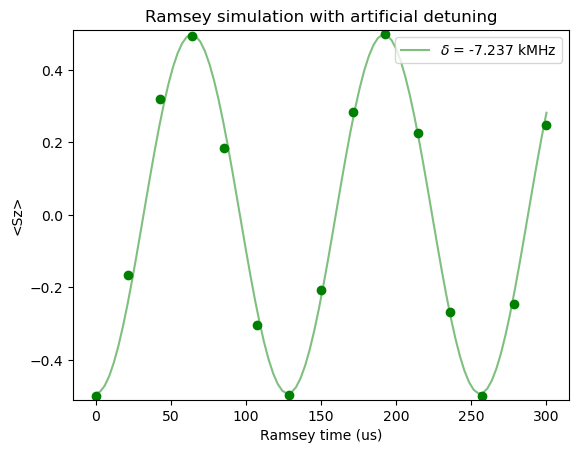

In [133]:
def ramsey_fit(t,f,a,b):
    return a*(b - np.cos(f*t))

fit_times = np.linspace(ramsey_times[0], ramsey_times[-1], 100)

guess = [ramsey_detuning, 0.5, 0]
popt, pcov = curve_fit(ramsey_fit, ramsey_times, sz_electron, guess)
plt.plot(ramsey_times, sz_electron, 'og')
plt.plot(fit_times, ramsey_fit(fit_times, *popt), 'g', alpha=0.5, label=r"$\delta$ = %.3f kMHz"%((ramsey_detuning - popt[0])*1e3))

plt.title("Ramsey simulation with artificial detuning")
plt.xlabel("Ramsey time (us)")
plt.ylabel("<Sz>")
plt.ylim([-0.51, 0.51])
plt.legend()

## Stark shift

We expect to observe an AC Stark shift proportional to the Rabi frequency of the drive $\chi = \Omega_R^2 / \delta$, where $\delta$ is the detuning with respect to the rotating frame frequency, given that $\delta>>\Omega_R$.

For the main transition $\delta$ corresponds to $A/2 = 2\pi\cdot20$ kHz.

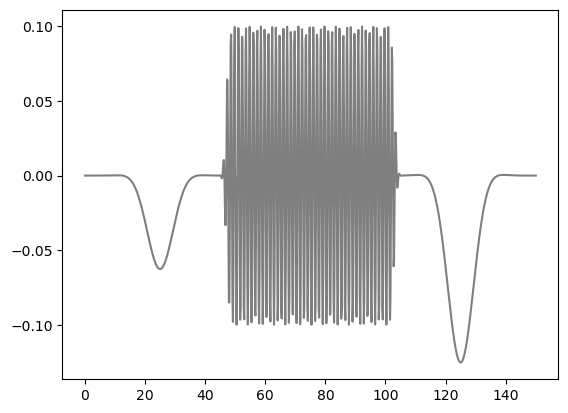

In [77]:
pulses, args_pulses = [], []

pulses.append("g")
args_pulses.append({
    'sigma_gauss': 30,
    'amplitude': 0.12534/2,
    't0': 10 + 15,
    'detuning': A/2,
    'phase': 0,
})

pulses.append("ft")
args_pulses.append({
    'sigma_raise': 1,
    'pulse_duration': 50,
    'amplitude': 0.1,
    't0': 10 + 30  + 10 + 25,
    'detuning': omega_L,
    'phase': 0,
})

pulses.append("g")
args_pulses.append({
    'sigma_gauss': 30,
    'amplitude': 0.12534,
    't0': 10 + 30 + 10 + 50 + 10 + 15,
    'detuning': A/2,
    'phase': 0,
})


seq_args = {"pulses": pulses, "args_pulses": args_pulses}

t = np.linspace(0, 150, 1000)
p = [pulse_sequence_p(_t, seq_args) for _t in t]
    
plt.figure()
plt.plot(t, p, 'k', alpha=0.5)

In [50]:
n_points

5

In [78]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop_p = [tensor(sigmap(),qeye(nI)), pulse_sequence_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), pulse_sequence_m]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 50
amplitudes = np.linspace(0.01, 1, n_points)
t = np.linspace(0, 150, 1000)

plot=False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []
for ii, amp in enumerate(amplitudes):    
    seq_args["args_pulses"][1]["amplitude"] = amp

    result = mesolve([H0, H_flattop_p, H_flattop_m], ket0, t, [], [], args=seq_args)
    res_e = expect(tensor(Sz, qeye(nI)), result.states)
    res_n = expect(tensor(qeye(nS), Sz), result.states)

    sz_electron.append(res_e[-1])
    sz_nuclear.append(res_n[-1])

    if plot:
        ax[ii].set_title("Rabi frequency = %.2f kHz | Ramsey time = %.2f us"%(amp/2/np.pi*1e3, r_time))
        ax[ii].plot(t, res_e, "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, res_n, "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [pulse_sequence_m(_t, seq_args) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()


In [80]:
def ramsey_fit(t,f,a,b, s):
    return a*(b - np.cos(f*t + s))

fit_amps = np.linspace(amplitudes[0], amplitudes[-1], 100)

plot = True
guess = [23, 0.5, 0, 0]
popt, pcov = curve_fit(amplitudes**2, ramsey_times, sz_e, guess)
if plot:
    plt.figure()
    plt.plot(amplitudes**2, sz_electron, 'go')
    plt.plot(fit_amps**2, ramsey_fit(fit_amps**2, *popt), 'g', alpha=0.5, label=r"$\delta$ = %.3f kMHz"%((ramsey_detuning - popt[0])*1e3))
    plt.xlabel("Amplitude (MHz)")

TypeError: 'numpy.ndarray' object is not callable

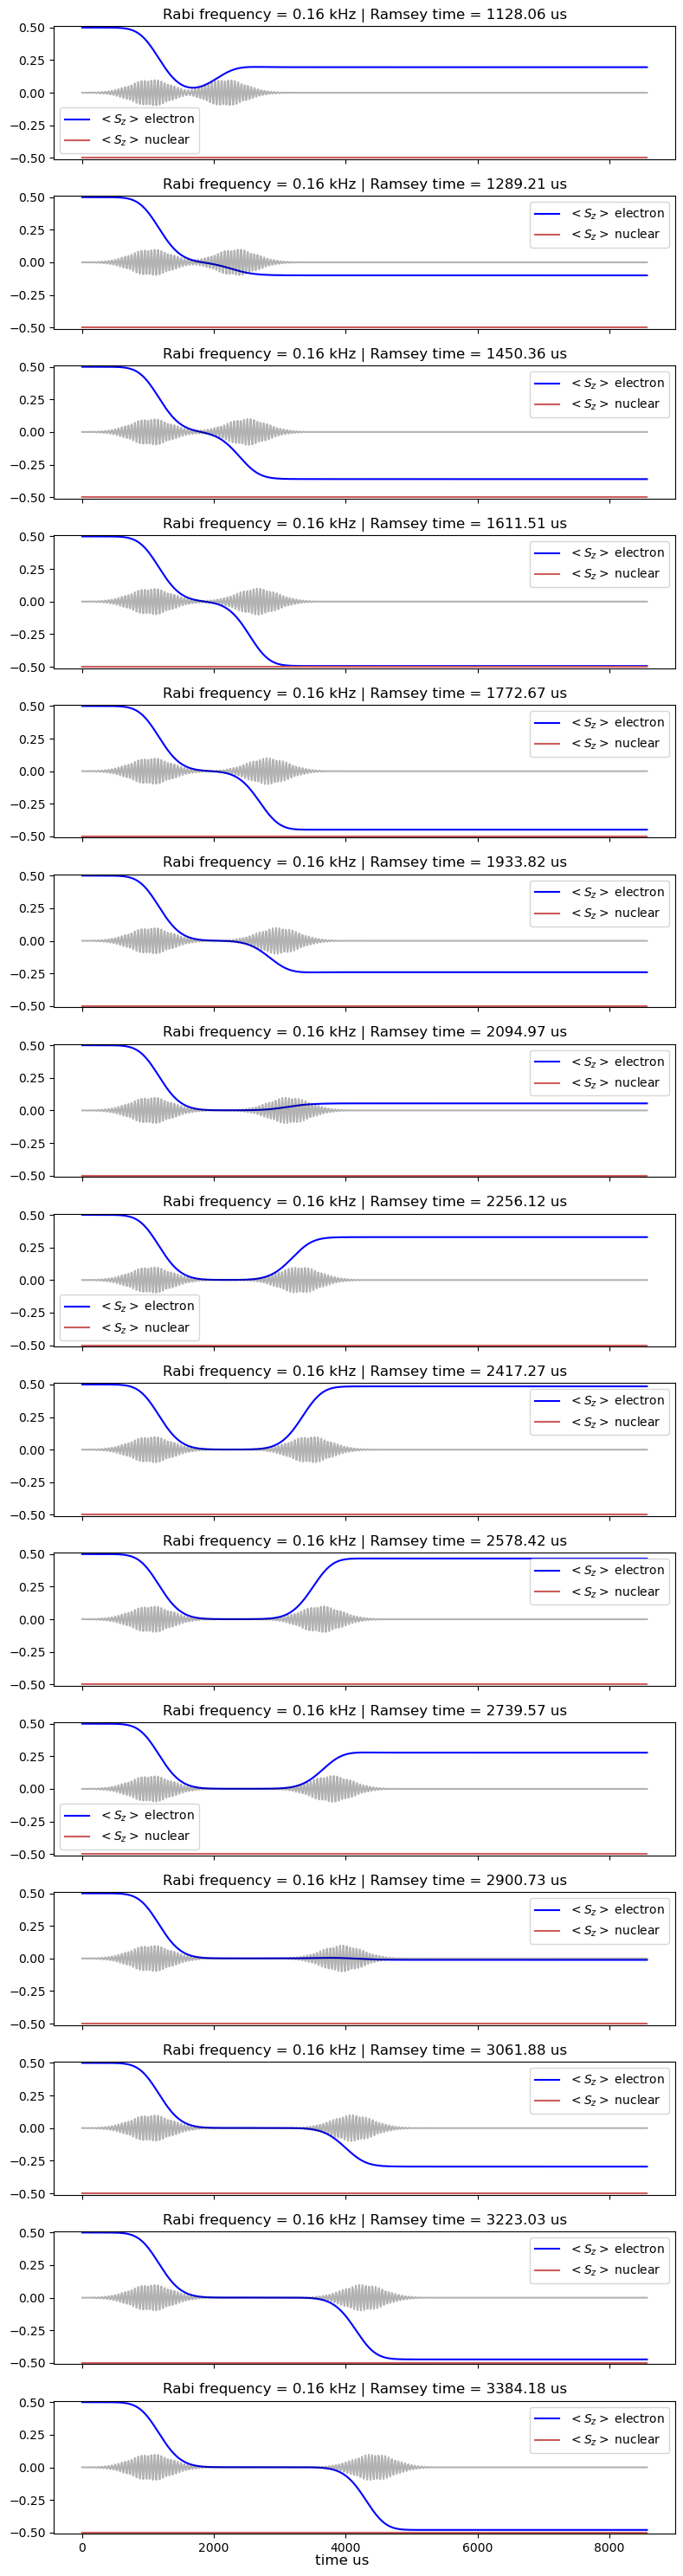

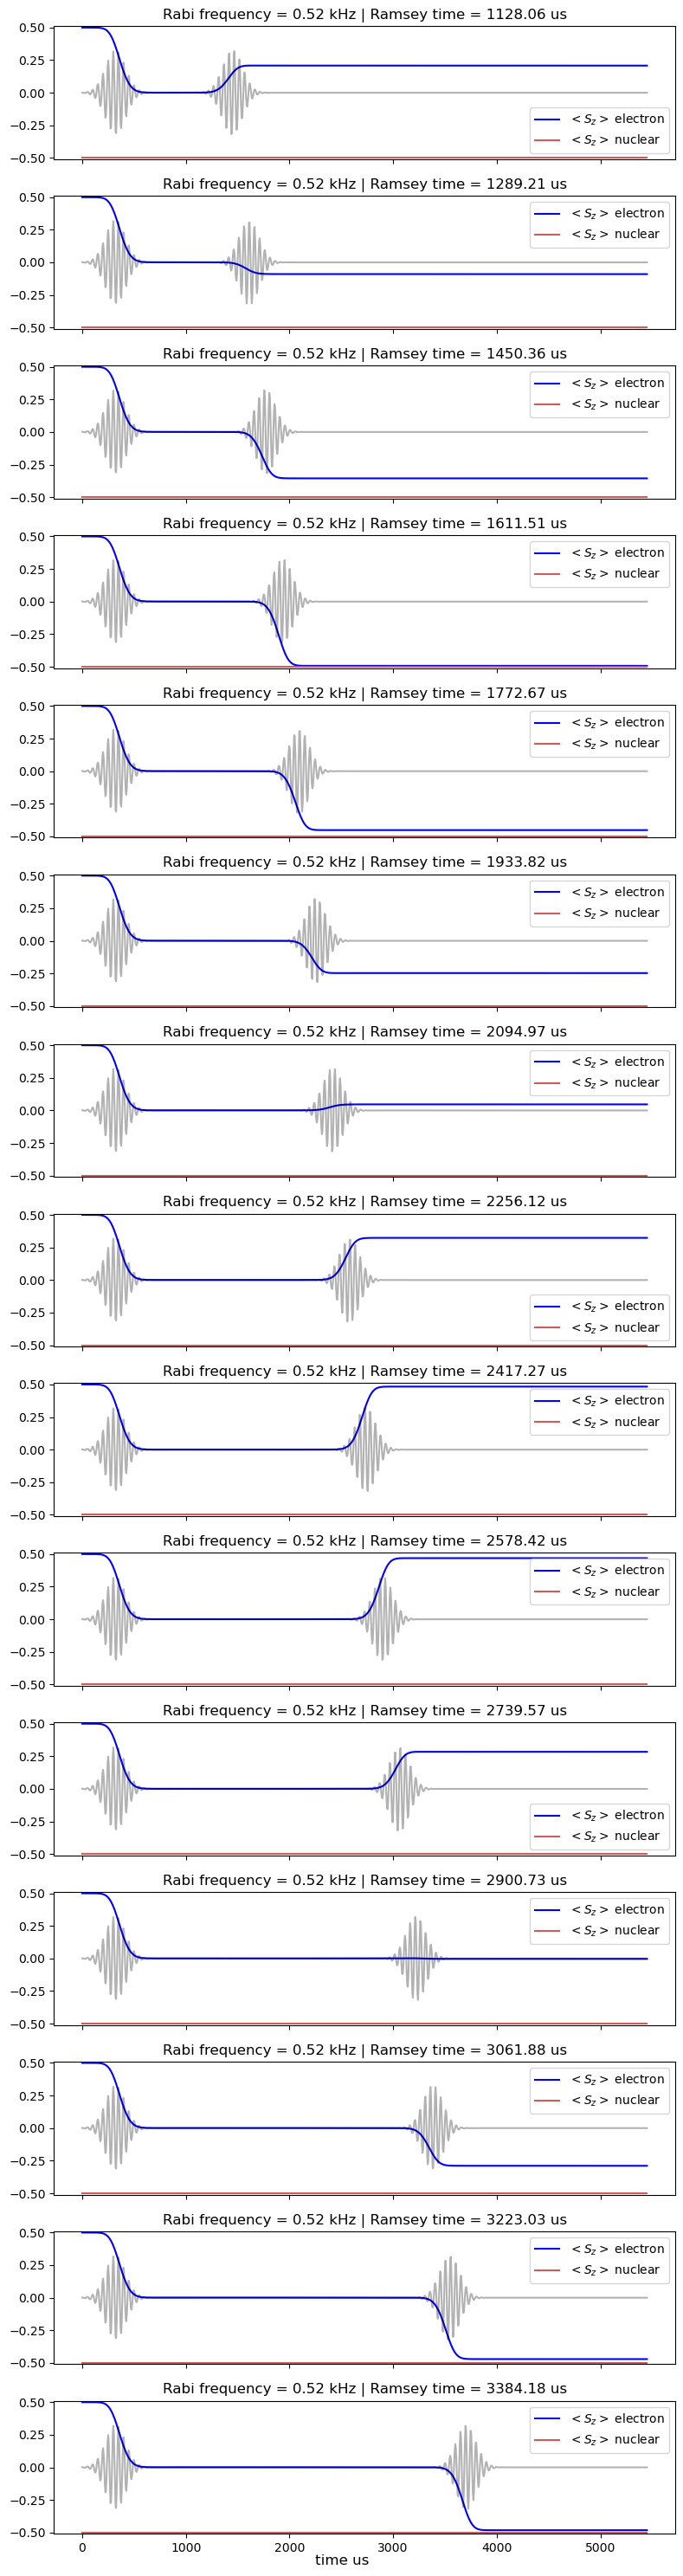

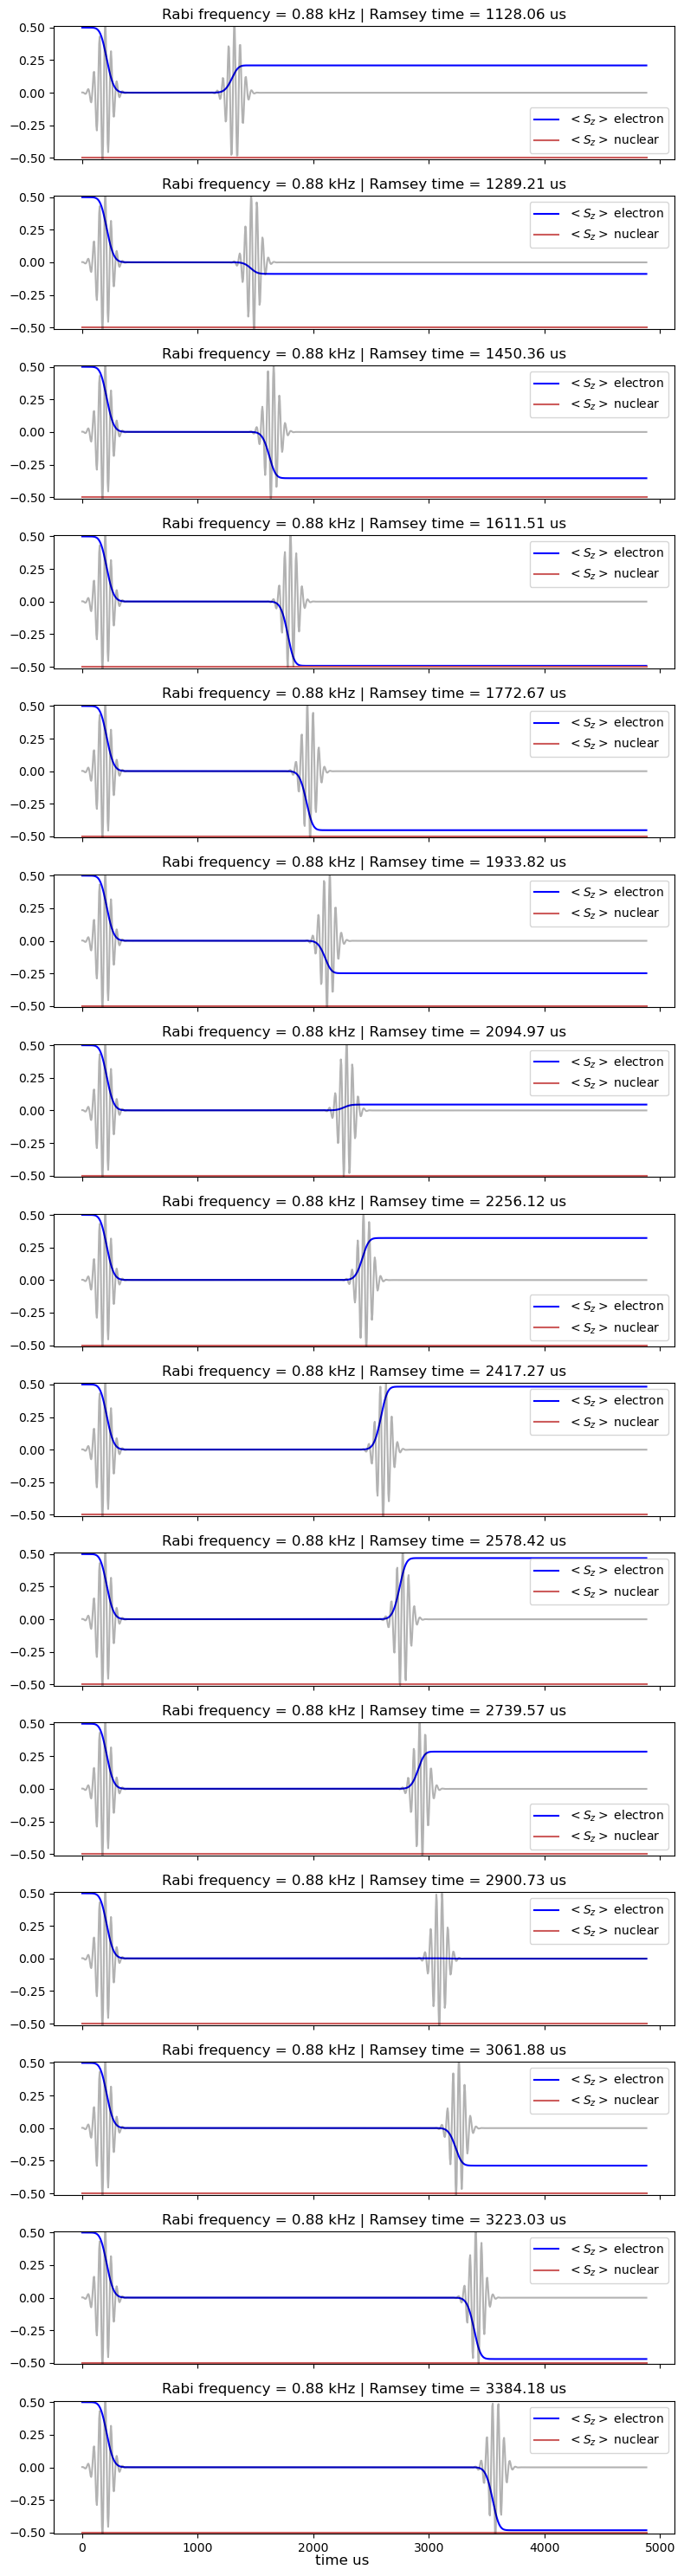

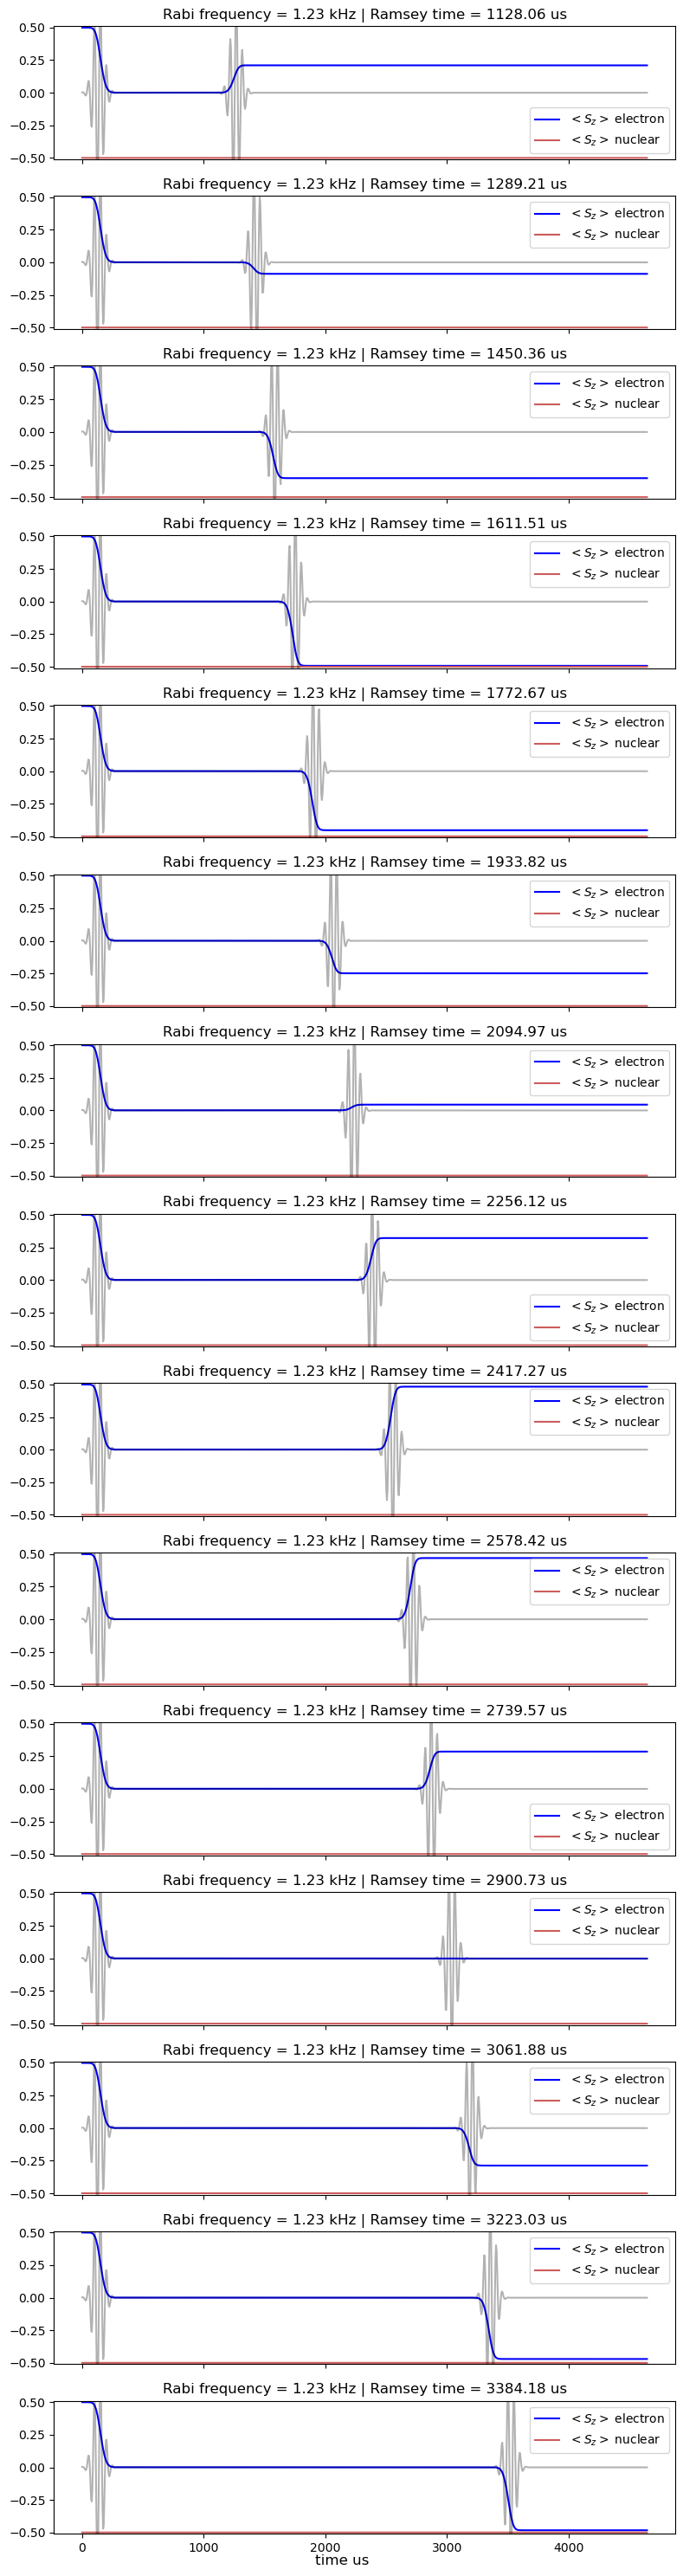

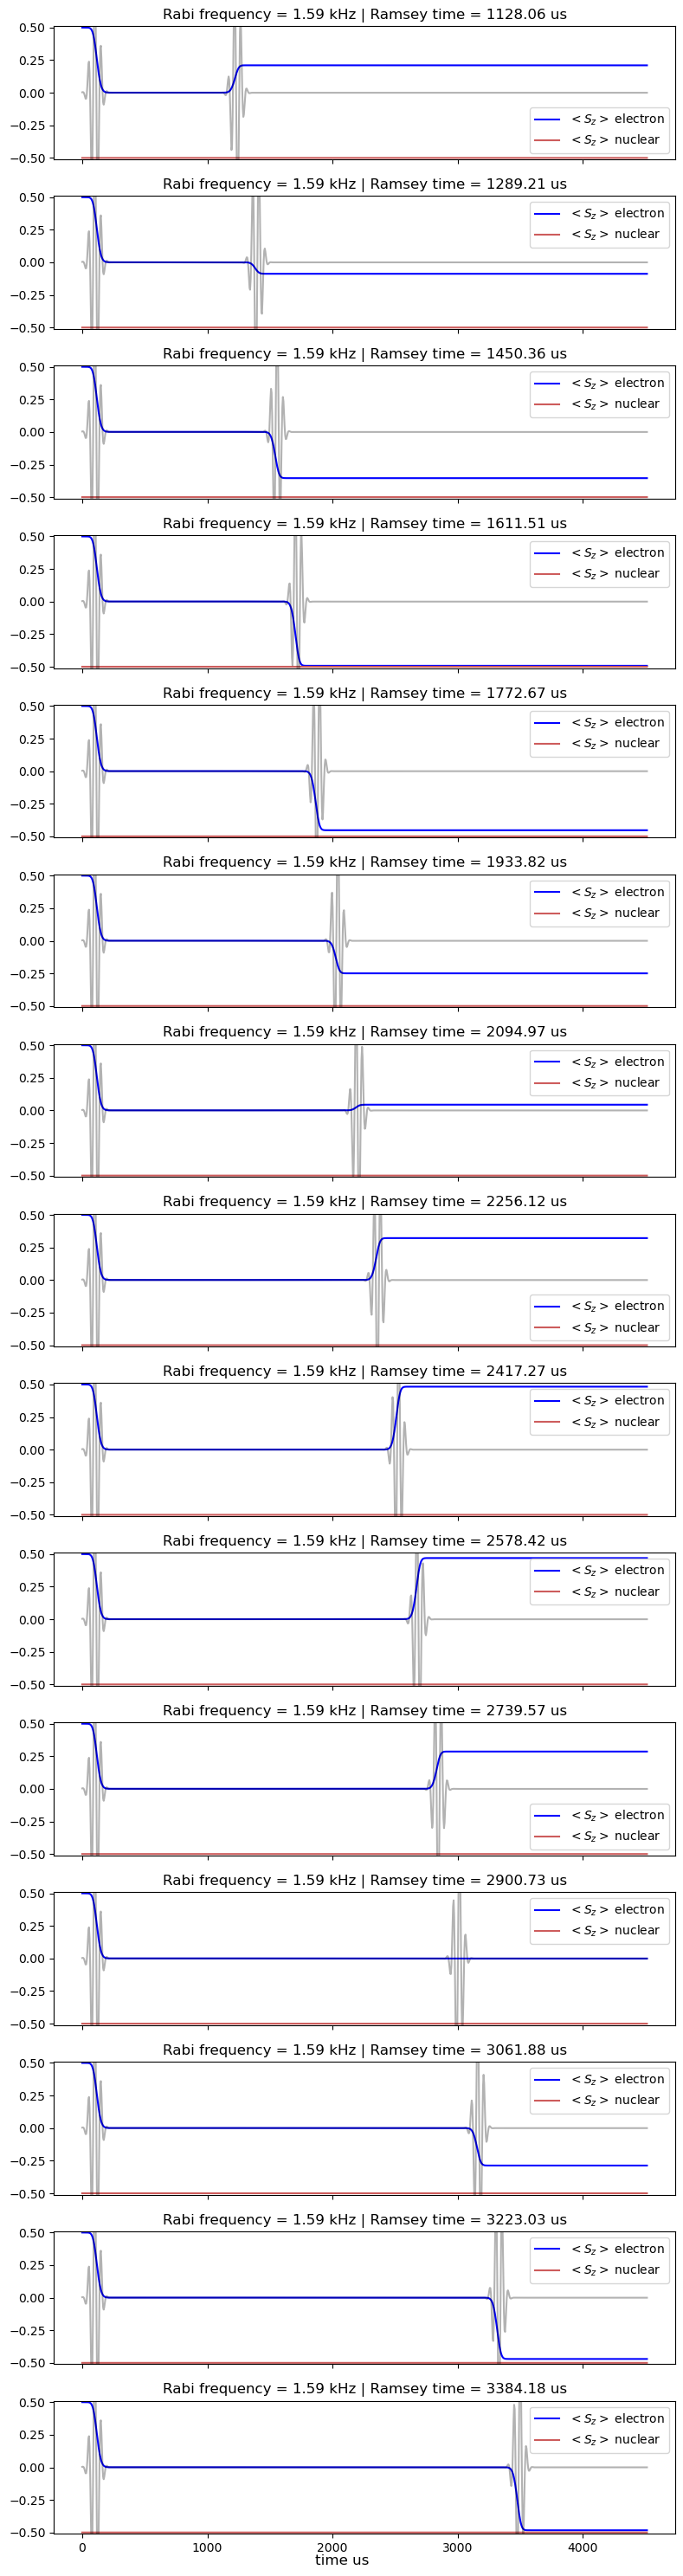

In [33]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop_p = [tensor(sigmap(),qeye(nI)), pulse_sequence_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), pulse_sequence_m]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 15

amplitudes = np.linspace(0.001, 0.010, 5)
t0  = 30 * 0.12534/2 / amplitudes
seq_args["args_pulses"][0]["t0"] = t0

max_pulse_duration = np.max(30 * 0.12534/2 / amplitudes)
ramsey_times = np.linspace(max_pulse_duration*6, max_pulse_duration*6*3, n_points)
ramsey_detuning = 2*np.pi/(ramsey_times[-1]) * 2 


sz_electron = []
sz_nuclear = []
for jj, amp in enumerate(amplitudes):
    pulse_duration = 30 * 0.12534/2 / amp
    
    seq_args["args_pulses"][0]["amplitude"] = amp
    seq_args["args_pulses"][0]["sigma_gauss"] = pulse_duration
    seq_args["args_pulses"][0]["t0"] = pulse_duration / 1.8
    
    seq_args["args_pulses"][1]["amplitude"] = amp
    seq_args["args_pulses"][1]["sigma_gauss"] = pulse_duration

    sequence_duration = (pulse_duration * 2 + ramsey_times[-1]) * 1.2

    plot=True
    if plot:
        fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
        fig.supxlabel("time us")
    
    sz_e, sz_n = [], []
    for ii, r_time in enumerate(ramsey_times):

        seq_args["args_pulses"][1]["t0"] = seq_args["args_pulses"][0]["t0"] + r_time
        seq_args["args_pulses"][1]["phase"] = r_time * ramsey_detuning
        t = np.linspace(0, sequence_duration, 1000)
        
        result = mesolve([H0, H_flattop_p, H_flattop_m], ket0, t, [], [], args=seq_args)
        res_e = expect(tensor(Sz, qeye(nI)), result.states)
        res_n = expect(tensor(qeye(nS), Sz), result.states)
    
        sz_e.append(res_e[-1])
        sz_n.append(res_n[-1])
    
        if plot:
            ax[ii].set_title("Rabi frequency = %.2f kHz | Ramsey time = %.2f us"%(amp/2/np.pi*1e3, r_time))
            ax[ii].plot(t, res_e, "b", label=r"$<S_z>$ electron")
            ax[ii].plot(t, res_n, "indianred", label=r"$<S_z>$ nuclear")
            ax[ii].plot(t, [pulse_sequence_m(_t, seq_args)*100 for _t in t], "k", alpha=0.3)
            ax[ii].set_ylim([-0.51, 0.51])
            ax[ii].legend()
    sz_electron.append(sz_e)
    sz_nuclear.append(sz_n)


delta = 0.80 kHz


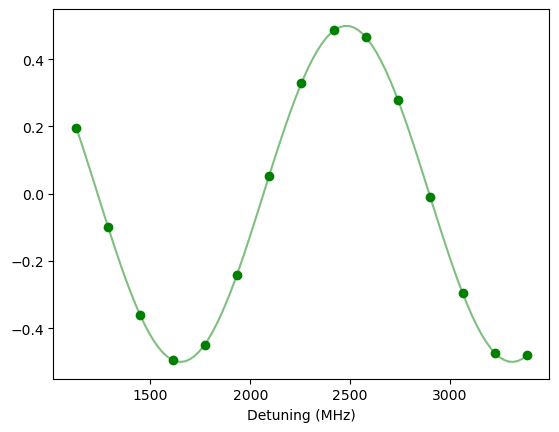

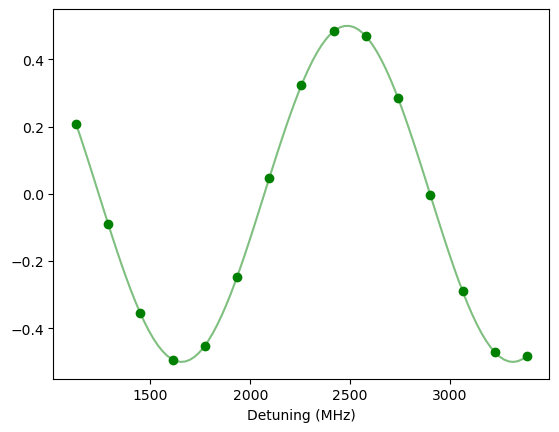

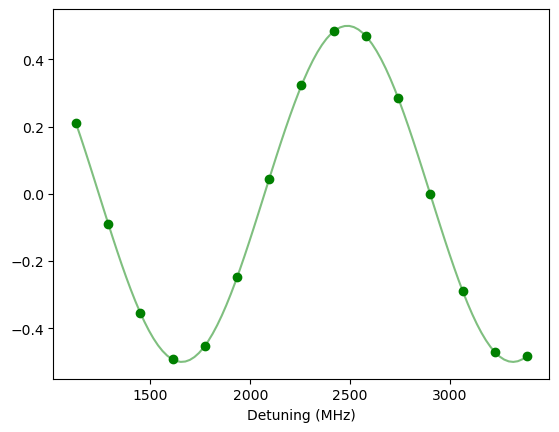

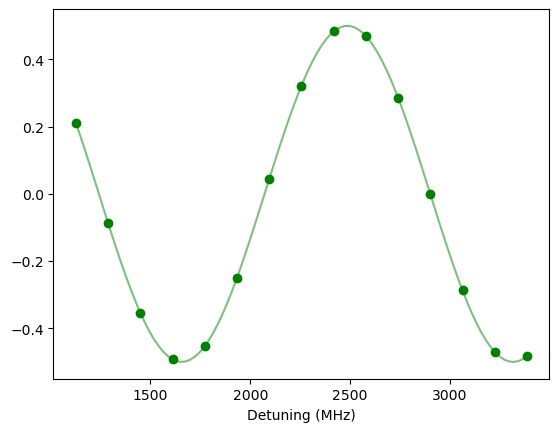

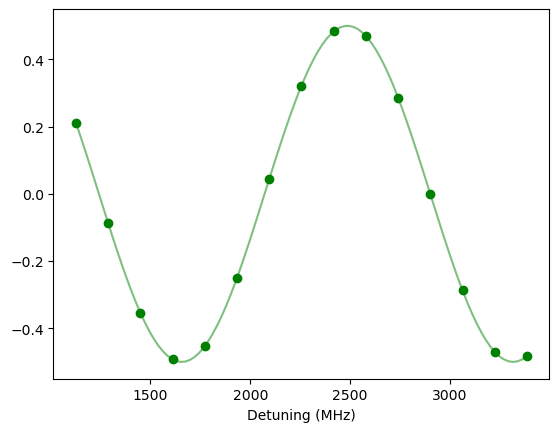

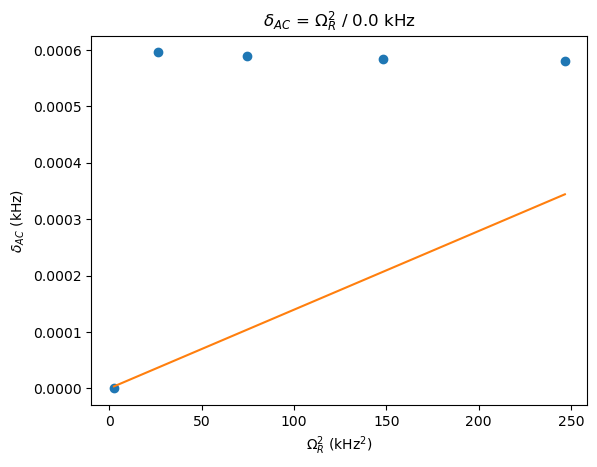

In [35]:
def ramsey_fit(t,f,a,b, s):
    return a*(b - np.cos(f*t + s))

fit_times = np.linspace(ramsey_times[0], ramsey_times[-1], 100)

plot = True
shift = []
for sz_e in sz_electron:
    guess = [ramsey_detuning, 0.5, 0, 0]
    popt, pcov = curve_fit(ramsey_fit, ramsey_times, sz_e, guess)
    shift.append(popt[0])
    if plot:
        plt.figure()
        plt.plot(ramsey_times, sz_e, 'go')
        plt.plot(fit_times, ramsey_fit(fit_times, *popt), 'g', alpha=0.5, label=r"$\delta$ = %.3f kMHz"%((ramsey_detuning - popt[0])*1e3))
        plt.xlabel("Detuning (MHz)")


shift0 = (shift-shift[0]) / (2*np.pi)  # Shift / 2pi in MHz
or2 = (amplitudes*1e3/2*np.pi)**2          # Square Rabi frequency in MHz
m, n = np.polyfit(or2, shift0, 1)
plt.figure()
plt.plot(or2, shift0*1e3, 'o')
plt.plot(or2, m*or2*1e3)
plt.xlabel(r"$\Omega_R^2$ (kHz$^2$)")
plt.ylabel(r"$\delta_{AC}$ (kHz)")
plt.title(r"$\delta_{AC}$ = $\Omega_R^2$ / %.1f kHz"%abs(m*1e3))
print("delta = %.2f kHz"%(omega_L/2/np.pi))

# Sideband flattop

In [ ]:
%matplotlib inline
ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

H_flattop_p = [tensor(sigmap(),qeye(nI)), flattop_pulse_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), flattop_pulse_m]

n_points = 501
detuning = omega_L*np.linspace(0.8, 1, n_points)
pulse_duration = 120

plot = False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

rab = []
t = np.linspace(0, pulse_duration+20, 1000)
for ii, det in enumerate(detuning):
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 30,
        'pulse_duration': pulse_duration,
        'amplitude': 0.05*25,
        't0': pulse_duration/2,
        'detuning': det, # 2pi*f in MHz
        'phase': 0
    }
    
    result = mesolve([H0, H_flattop_p, H_flattop_m], ket0, t, [], [], args=args)
    rab.append(expect(tensor(qeye(nS), Sz), result.states)[-1])
    if plot:
        ax[ii].plot(t, expect(tensor(Sz, qeye(nI)), result.states), 'b',label="Detuning = %.2f kHz"%(det/2/np.pi*1e3))
        ax[ii].plot(t, expect(tensor(qeye(nS), Sz), result.states), 'r',label="Detuning = %.2f kHz"%(det/2/np.pi*1e3))
        ax[ii].plot(t, [flattop_pulse(_t, args) for _t in t], alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()


In [405]:
from scipy.optimize import curve_fit

[0.6970263471980759, 0.003210623432510713, 0.5910332512146199, -0.49998976661775896]


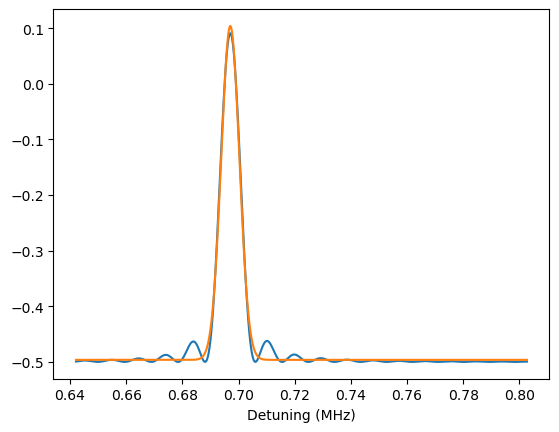

In [425]:
def gaussian_fit(x, x0, sigma, a, b):
    return a * np.exp(-((x-x0)/(2*sigma))**2) + b

x = detuning/2/np.pi
guess = [x[np.argmax(rab)], (x[-1]-x[0])/50, np.max(rab)-np.min(rab), np.min(rab)]
popt, pcov = curve_fit(gaussian_fit, x, rab, guess)

plt.figure()
plt.plot(x, rab)
plt.plot(x, gaussian_fit(x, *popt))
plt.xlabel("Detuning (MHz)")
print(guess)

In [474]:
0.05*25 / omega_L

0.24785675809921426

# Sideband stark shift

In [ ]:
%matplotlib inline
ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

H_flattop_p = [tensor(sigmap(),qeye(nI)), flattop_pulse_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), flattop_pulse_m]

n_points = 101
amplitudes = 0.05*np.linspace(1, 25, 10)
detuning = omega_L*np.linspace(0.85, 1.05, n_points)
pulse_duration = 120

rabrab = []
for jj, amp in enumerate(amplitudes):
    rab = []
    t = np.linspace(0, pulse_duration+20, 1000)
    for ii, det in enumerate(detuning):
        args = {
            'sigma_raise': 1,
            'sigma_gauss': 30,
            'pulse_duration': pulse_duration,
            'amplitude': amp,
            't0': pulse_duration/2,
            'detuning': det, # 2pi*f in MHz
            'phase': 0
        }
        
        result = mesolve([H0, H_flattop_p, H_flattop_m], ket0, t, [], [], args=args)
        rab.append(expect(tensor(qeye(nS), Sz), result.states)[-1])
    rabrab.append(rab)

plot = False
shift = []
for rab in rabrab:
    guess = [detuning[np.argmax(rab)], (detuning[-1]-detuning[0])/50, np.max(rab)-np.min(rab), np.min(rab)]
    popt, pcov = curve_fit(gaussian_fit, detuning, rab, guess)
    shift.append(popt[0])
    if plot:
        plt.figure()
        plt.plot(detuning, rab)
        plt.plot(detuning, gaussian_fit(detuning, *popt))
        plt.xlabel("Detuning (MHz)")
        


delta = 0.80 kHz


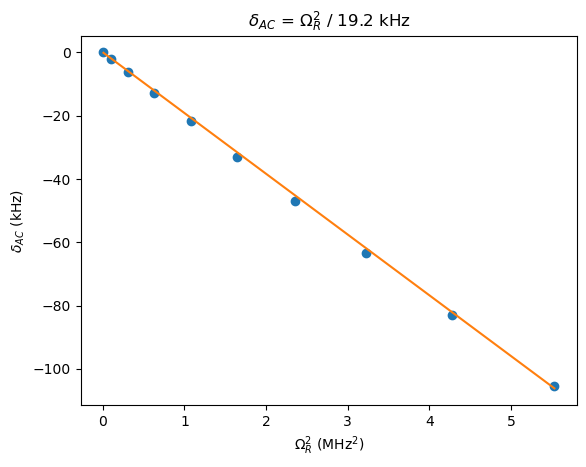

In [472]:
shift0 = (shift-shift[0]) / (2*np.pi)  # Shift / 2pi in MHz
or2 = (amplitudes/2*np.pi)**2          # Square Rabi frequency in MHz
m, n = np.polyfit(or2, shift0, 1)
plt.figure()
plt.plot(or2, shift0*1e3, 'o')
plt.plot(or2, m*or2*1e3)
plt.xlabel(r"$\Omega_R^2$ (MHz$^2$)")
plt.ylabel(r"$\delta_{AC}$ (kHz)")
plt.title(r"$\delta_{AC}$ = $\Omega_R^2$ / %.1f kHz"%abs(m*1e3))
print("delta = %.2f kHz"%(omega_L/2/np.pi))

In [399]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop_p = [tensor(sigmap(),qeye(nI)), flattop_pulse_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), flattop_pulse_m]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
pulse_duration = np.linspace(0, 200, 30)

sz_e = []
sz_n = []
for dur in pulse_duration:
    t = np.linspace(0, amp+20, 1000)
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 5,
        'pulse_duration': dur,
        'amplitude': 0.05*25,
        't0': dur/2+10,
        'detuning': 2*np.pi*0.697, # 2pi*f in MHz
        'phase': 0
    }
    result = mesolve([H0, H_flattop_p, H_falttop_m], ket0, t, [], [], args=args)
    sz_e.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    sz_n.append(expect(tensor(qeye(nI), Sz), result.states)[-1])

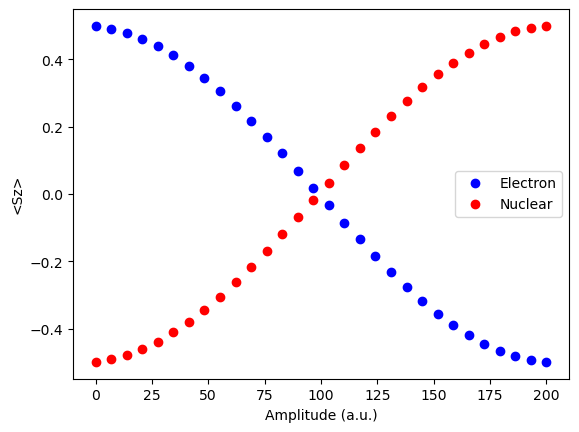

In [403]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

guess = [5, 0.5, 0]
#popt, pcov = curve_fit(rabi_fit, amplitudes, sz_falttop, guess)
plt.plot(pulse_duration, sz_e, 'ob', label="Electron")
plt.plot(pulse_duration, sz_n, 'or', label="Nuclear")
#plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'g', alpha=0.5, label="sideband flattop amp: %.5f"%(1/popt[0]/2))

plt.xlabel("Pulse duration (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

# Composite 3 pulse Rabi

In [ ]:
# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = 30
sb_rise = 1
sb_amplitude = 0.0872
sb_t = 20

us_duration = 5 / 6
us_amplitude = 0.2507 * 6
us_t = 20 + 50

s_duration = 80 / 6
s_amplitude = us_amplitude / s_duration * us_duration 
s_t = 20 + 50 + 50

phase = 0

pulses.append("ft")
args_pulses.append({
    'sigma_raise': sb_rise,
    'sigma_gauss': 5,
    'pulse_duration': 40,
    'amplitude': 0.01,
    't0': 120,
    'detuning': omega_L,
    'phase': pase
})

pulses.append("s")
args_pulses.append({
    'sigma_raise': 1,
    'sigma_gauss': 5,
    'pulse_duration': 20,
    'amplitude': 0.08,
    't0': 20,
    'detuning': -A/2,
    'phase': phase
})

pulses.append("g")
args_pulses.append({
    'sigma_raise': 1,
    'sigma_gauss': 5,
    'pulse_duration': 20,
    'amplitude': 0.2,
    't0': 70,
    'detuning': A/2,
    'phase': pase
})





args_3_composite = {
        'pulse_duration_ft': sb_duration,
        'sigma_raise_ft': sb_rise,
        'amplitude_ft': sb_amplitude,
        't0_ft': sb_t,

        'sigma_gauss_g1': us_duration,
        'amplitude_g1': us_amplitude,
        't0_g1': us_t,
                      
        'sigma_raise_g2': s_duration,
        'amplitude_g2': s_amplitude,
        't0_g2': s_t,
    
        'sequence_delay': 0 ,         
        'detuning_sb': omega_L,
        'detuning_b': -A/2,
        'phase': phase,
}

t = np.linspace(0, 200, 100000)
ft3 = [three_pulse_train(_t, args_3_composite) for _t in t]
    
plt.figure()
plt.plot(t, ft3, alpha=0.5, label="Flatop")
plt.legend()

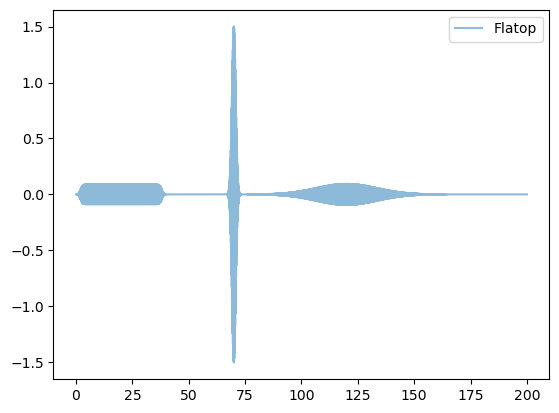

In [63]:
def three_pulse_train(t, args):
    args_flattop_sb = {
        'pulse_duration': args['pulse_duration_ft'],
        'sigma_raise':    args['sigma_raise_ft'],
        'amplitude':      args['amplitude_ft'],
        't0':             args['t0_ft'] + args['sequence_delay'], 
        'detuning':       args['detuning_sb'],
        'phase':          args['phase'],
    }
    args_gauss_us = {
        'sigma_gauss':    args['sigma_gauss_g1'],
        'amplitude':      args['amplitude_g1'],
        't0':             args['t0_g1'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_s = {
        'sigma_gauss':    args['sigma_raise_g2'],
        'amplitude':      args['amplitude_g2'],
        't0':             args['t0_g2'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    return flattop_pulse(t, args_flattop_sb) + gaussian_pulse(t, args_gauss_us) + gaussian_pulse(t, args_gauss_s)

# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = 30
sb_rise = 1
sb_amplitude = 0.0872
sb_t = 20

us_duration = 5 / 6
us_amplitude = 0.2507 * 6
us_t = 20 + 50

s_duration = 80 / 6
s_amplitude = us_amplitude / s_duration * us_duration 
s_t = 20 + 50 + 50

phase = 0

args_3_composite = {
        'pulse_duration_ft': sb_duration,
        'sigma_raise_ft': sb_rise,
        'amplitude_ft': sb_amplitude,
        't0_ft': sb_t,

        'sigma_gauss_g1': us_duration,
        'amplitude_g1': us_amplitude,
        't0_g1': us_t,
                      
        'sigma_raise_g2': s_duration,
        'amplitude_g2': s_amplitude,
        't0_g2': s_t,
    
        'sequence_delay': 0 ,         
        'detuning_sb': omega_L,
        'detuning_b': -A/2,
        'phase': phase,
}

t = np.linspace(0, 200, 100000)
ft3 = [three_pulse_train(_t, args_3_composite) for _t in t]
    
plt.figure()
plt.plot(t, ft3, alpha=0.5, label="Flatop")
plt.legend()

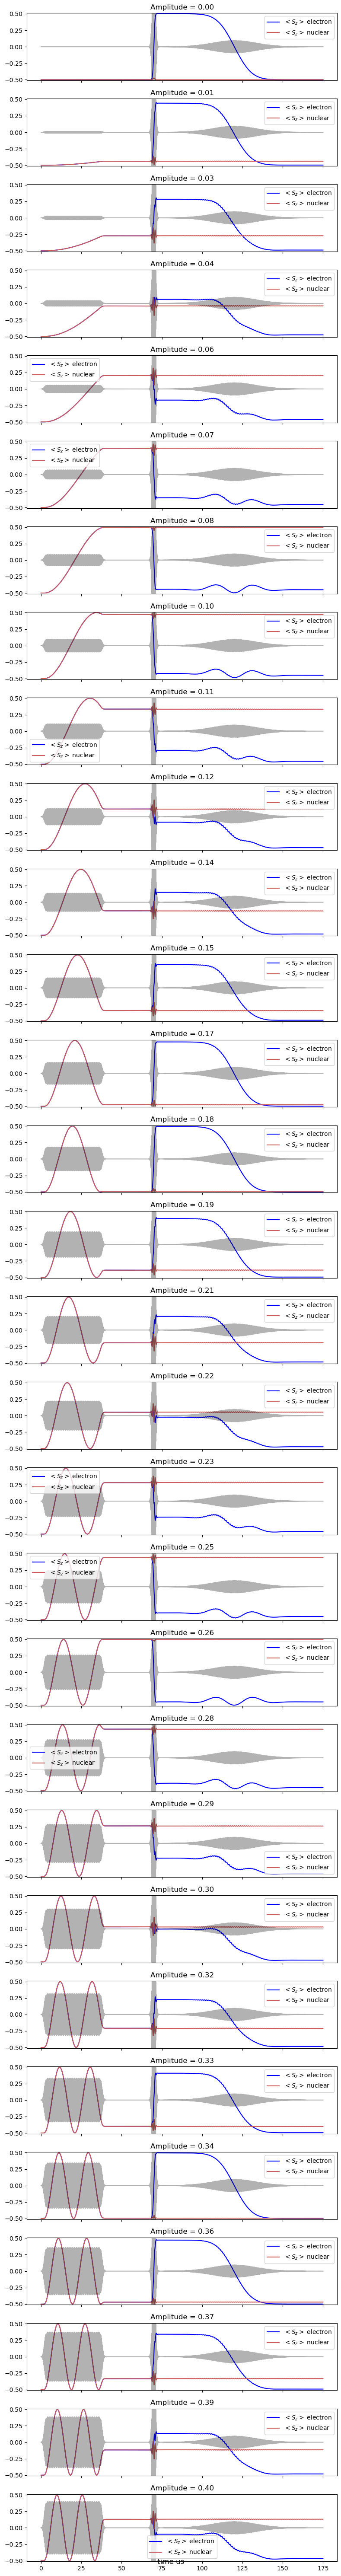

In [35]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop = [tensor(sigmay(),sigmay()) + tensor(sigmay(),qeye(nI)), three_pulse_train]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 30
amplitudes = np.linspace(0, 0.4, n_points)
t = np.linspace(0, 175, 5000)

plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, amp in enumerate(amplitudes):
    args_3_composite["amplitude_ft"] = amp
    result = mesolve([H0, H_flattop], ket0, t, [], [], args=args_3_composite)
    sz_electron.append(expect(tensor(Sz, qeye(nI)), result.states))
    sz_nuclear.append(expect(tensor(qeye(nS), Sz), result.states))
    if plot:
        ax[ii].set_title("Amplitude = %.2f"%(amp))
        ax[ii].plot(t, sz_electron[-1], "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, sz_nuclear[-1], "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [three_pulse_train(_t, args_3_composite) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

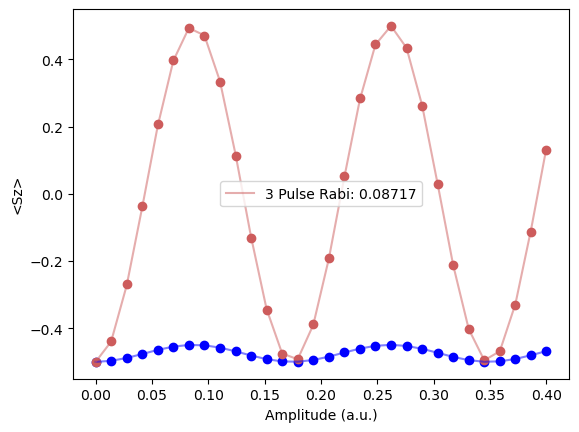

In [38]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

sz_electron_end = np.array(sz_electron)[:, -1]
sz_nuclear_end = np.array(sz_nuclear)[:, -1]
guess = [5, 0.5, 0]
popt_e, pcov_e = curve_fit(rabi_fit, amplitudes, sz_electron_end, guess)
popt_n, pcov_n = curve_fit(rabi_fit, amplitudes, sz_nuclear_end, guess)

plt.plot(amplitudes, sz_electron_end, 'o', color="b")
plt.plot(amplitudes, sz_nuclear_end, 'o', color="indianred")

plt.plot(amplitudes, rabi_fit(amplitudes, *popt_e), 'b', alpha=0.5)
plt.plot(amplitudes, rabi_fit(amplitudes, *popt_n), 'indianred', alpha=0.5, label="3 Pulse Rabi: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

# Composite 5 pulse Rabi

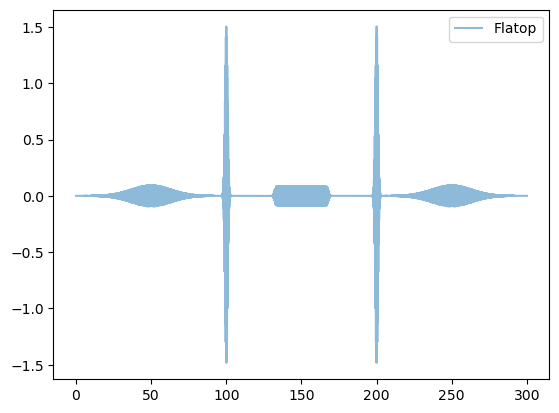

In [51]:
def five_pulse_train(t, args):
    args_gauss_s1 = {
        'sigma_gauss':    args['s_sigma_gauss'],
        'amplitude':      args['s_amplitude'],
        't0':             args['s_t1'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_us1 = {
        'sigma_gauss':    args['us_sigma_gauss'],
        'amplitude':      args['us_amplitude'],
        't0':             args['us_t2'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_flattop_sb = {
        'pulse_duration': args['sb_pulse_duration'],
        'sigma_raise':    args['sb_sigma_raise'],
        'amplitude':      args['sb_amplitude'],
        't0':             args['sb_t0'],
        'detuning':       args['detuning_sb'],
        'phase':          args['phase'],
    }
    args_gauss_us2 = {
        'sigma_gauss':    args['us_sigma_gauss'],
        'amplitude':      args['us_amplitude'],
        't0':             args['us_t3'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_s2 = {
        'sigma_gauss':    args['s_sigma_gauss'],
        'amplitude':      args['s_amplitude'],
        't0':             args['s_t4'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    outpulse = (
        gaussian_pulse(t, args_gauss_s1) + gaussian_pulse(t, args_gauss_us1) +
        flattop_pulse(t, args_flattop_sb) + 
        gaussian_pulse(t, args_gauss_us2)  + gaussian_pulse(t, args_gauss_s2)
    )
    return outpulse

pulse_delay = 50

# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = 30
sb_rise = 1
sb_amplitude = 0.0872
sb_t = pulse_delay*3

us_duration = 5 / 6
us_amplitude = 0.2507 * 6
us_t2 = pulse_delay*2
us_t3 = pulse_delay*4

s_duration = 80 / 6
s_amplitude = us_amplitude / s_duration * us_duration 
s_t1 = pulse_delay
s_t4 = pulse_delay*5

phase = 0

args_5_composite = {
        'sb_pulse_duration': sb_duration,
        'sb_sigma_raise': sb_rise,
        'sb_amplitude': sb_amplitude,
        'sb_t0': sb_t,

        'us_sigma_gauss': us_duration,
        'us_amplitude': us_amplitude,
        'us_t2': us_t2,
        'us_t3': us_t3,
                      
        's_sigma_gauss': s_duration,
        's_amplitude': s_amplitude,
        's_t1': s_t1,
        's_t4': s_t4,
                      
        'detuning_sb': omega_L,
        'detuning_b': -A/2,
        'phase': phase,
}

t = np.linspace(0, 6*pulse_delay, 10000)
ft5 = [five_pulse_train(_t, args_5_composite) for _t in t]
    
plt.figure()
plt.plot(t, ft5, alpha=0.5, label="Flatop")
plt.legend()

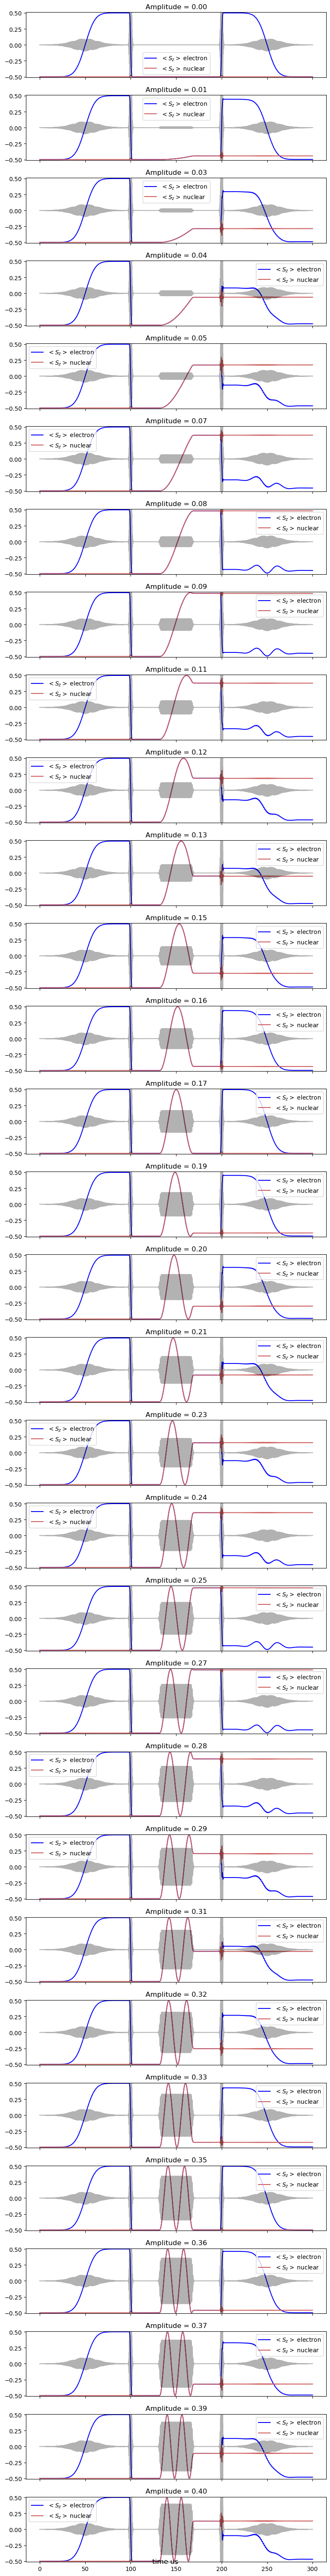

In [57]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop = [tensor(sigmay(),sigmay()) + tensor(sigmay(),qeye(nI)), five_pulse_train]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 31
amplitudes = np.linspace(0, 0.4, n_points)
t = np.linspace(0, 6*pulse_delay, 5000)

plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, amp in enumerate(amplitudes):
    args_5_composite["sb_amplitude"] = amp
    result = mesolve([H0, H_flattop], ket0, t, [], [], args=args_5_composite)
    sz_electron.append(expect(tensor(Sz, qeye(nI)), result.states))
    sz_nuclear.append(expect(tensor(qeye(nS), Sz), result.states))
    if plot:
        ax[ii].set_title("Amplitude = %.2f"%(amp))
        ax[ii].plot(t, sz_electron[-1], "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, sz_nuclear[-1], "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [five_pulse_train(_t, args_5_composite) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

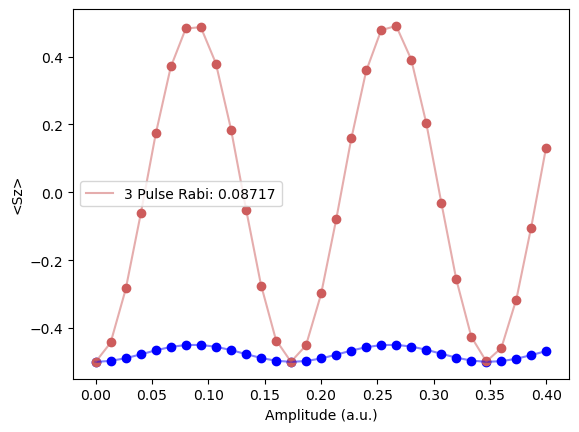

In [58]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

sz_electron_end = np.array(sz_electron)[:, -1]
sz_nuclear_end = np.array(sz_nuclear)[:, -1]
guess = [5, 0.5, 0]
popt_e, pcov_e = curve_fit(rabi_fit, amplitudes, sz_electron_end, guess)
popt_n, pcov_n = curve_fit(rabi_fit, amplitudes, sz_nuclear_end, guess)

plt.plot(amplitudes, sz_electron_end, 'o', color="b")
plt.plot(amplitudes, sz_nuclear_end, 'o', color="indianred")

plt.plot(amplitudes, rabi_fit(amplitudes, *popt_e), 'b', alpha=0.5)
plt.plot(amplitudes, rabi_fit(amplitudes, *popt_n), 'indianred', alpha=0.5, label=" Pulse Rabi: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

# Nuclear Ramsey Sequence

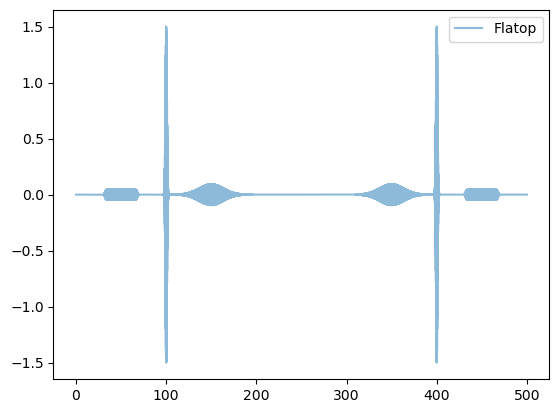

In [13]:
def three_pulse_train_ramsey(t, args):
    args_flattop_sb1 = {
        'pulse_duration': args['pulse_duration_ft'],
        'sigma_raise':    args['sigma_raise_ft'],
        'amplitude':      args['amplitude_ft'],
        't0':             args['t0_ft'] + args['sequence_delay'], 
        'detuning':       args['detuning_sb'],
        'phase':          args['phase'],
    }
    args_gauss_us1 = {
        'sigma_gauss':    args['sigma_gauss_g1'],
        'amplitude':      args['amplitude_g1'],
        't0':             args['t0_g1'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_s1 = {
        'sigma_gauss':    args['sigma_raise_g2'],
        'amplitude':      args['amplitude_g2'],
        't0':             args['t0_g2'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    
    args_gauss_s2 = args_gauss_s1.copy()
    args_gauss_s2['t0'] =  args_gauss_s1['t0'] + args['t0_ft'] + args["ramsey_delay"]
    
    args_gauss_us2 = args_gauss_us1.copy()
    args_gauss_us2['t0'] =  args_gauss_s1['t0'] + args['t0_g1'] + args["ramsey_delay"]

    args_flattop_sb2 = args_flattop_sb1.copy()
    args_flattop_sb2['t0'] =  args_gauss_s1['t0'] + args['t0_g2'] + args["ramsey_delay"]
    args_flattop_sb2['phase'] =  ramsey_detuning*t
    
    outpulse = (
        flattop_pulse(t, args_flattop_sb1) + gaussian_pulse(t, args_gauss_us1) + gaussian_pulse(t, args_gauss_s1) + 
        gaussian_pulse(t, args_gauss_s2) + gaussian_pulse(t, args_gauss_us2) + flattop_pulse(t, args_flattop_sb2) 
    )
    
    return outpulse

ramsey_detuning = 0
sequence_delay = 50
ramsey_delay = 200
pulse_delay = 50
phase = 0

# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = 30
sb_rise = 1
sb_amplitude = 0.0872/2
sb_t = 0

us_duration = 5 / 6
us_amplitude = 0.2507 * 6
us_t = pulse_delay

s_duration = 80 / 6
s_amplitude = us_amplitude / s_duration * us_duration 
s_t = pulse_delay*2


args = {
        'pulse_duration_ft': sb_duration,
        'sigma_raise_ft': sb_rise,
        'amplitude_ft': sb_amplitude,
        't0_ft': sb_t,

        'sigma_gauss_g1': us_duration,
        'amplitude_g1': us_amplitude,
        't0_g1': us_t,
                      
        'sigma_raise_g2': s_duration,
        'amplitude_g2': s_amplitude,
        't0_g2': s_t,

        'ramsey_detuning': ramsey_detuning,
        'sequence_delay': sequence_delay,
        'ramsey_delay': ramsey_delay,
        'detuning_sb': omega_L,
        'detuning_b': -A/2,
        'phase': phase,
}

t = np.linspace(0, 5*pulse_delay + sequence_delay + ramsey_delay, 100000)
ft3 = [three_pulse_train_ramsey(_t, args) for _t in t]
    
plt.figure()
plt.plot(t, ft3, alpha=0.5, label="Flatop")
plt.legend()

In [ ]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_pulses = [tensor(sigmay(),sigmay()) + tensor(sigmay(),qeye(nI)), three_pulse_train_ramsey]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 30
ramsey_times = np.linspace(100, 150, n_points)


plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, ramsey_delay in enumerate(ramsey_times):
    args["ramsey_delay"] = ramsey_delay
    t = np.linspace(0, 5*pulse_delay + sequence_delay + ramsey_delay, 10001)
    
    result = mesolve([H0, H_pulses], ket0, t, [], [], args=args)
    sz_electron.append(expect(tensor(Sz, qeye(nI)), result.states))
    sz_nuclear.append(expect(tensor(qeye(nS), Sz), result.states))
    if plot:
        ax[ii].set_title("Ramsey time = %.2f us"%(ramsey_delay))
        ax[ii].plot(t, sz_electron[-1], "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, sz_nuclear[-1], "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [three_pulse_train_ramsey(_t, args) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

plt.savefig("figs/fig.pdf")

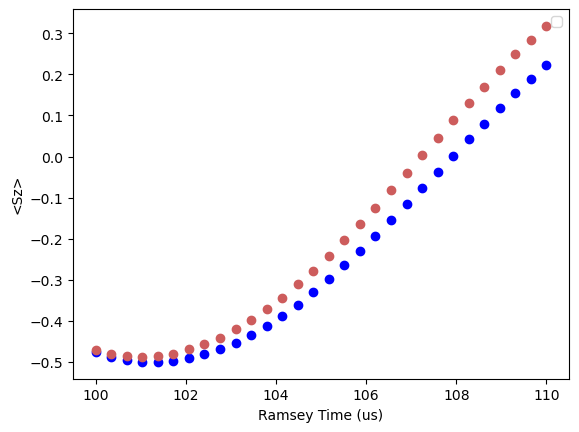

In [17]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

sz_electron_end = np.array(sz_electron)[:, -1]
sz_nuclear_end = np.array(sz_nuclear)[:, -1]

plt.plot(ramsey_times, sz_electron_end, 'o', color="b")
plt.plot(ramsey_times, sz_nuclear_end, 'o', color="indianred")

plt.xlabel("Ramsey Time (us)")
plt.ylabel("<Sz>")
plt.legend()

# Raman

In [21]:
raman_duration

360.00000000000006

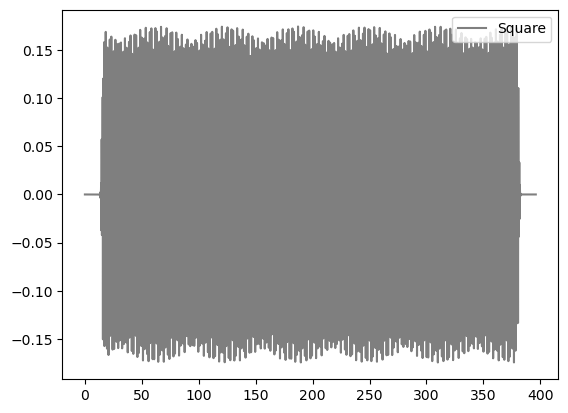

In [25]:
detuning_MHz = 0.4 # MHz
rabi_freq_sb = 1/30 # MHz
raman_rabi_freq = rabi_freq_sb**2 / detuning_MHz
raman_duration = 1 / raman_rabi_freq

# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = raman_duration
sb_rise = 1
sb_amplitude = 0.0872
sb_t = 20
phase = 0
detuning = 2*np.pi*detuning_MHz

pulses, args_pulses = [], []

pulses.append("ft")
args_pulses.append({
    'sigma_raise': sb_rise,
    'pulse_duration': sb_duration,
    'amplitude': sb_amplitude,
    't0': sb_duration/2*1.1,
    'detuning': omega_L + detuning,
    'phase': phase
})

pulses.append("ft")
args_pulses.append({
    'sigma_raise': sb_rise,
    'pulse_duration': sb_duration,
    'amplitude': sb_amplitude,
    't0': sb_duration/2*1.1,
    'detuning': -A/2 + detuning,
    'phase': phase
})


seq_args = {"pulses": pulses, "args_pulses": args_pulses}

t = np.linspace(0, raman_duration*1.1, 5000)
p = [pulse_sequence(_t, seq_args) for _t in t]
    
plt.figure()
plt.plot(t, p, 'k', alpha=0.5, label="Square")
plt.legend()

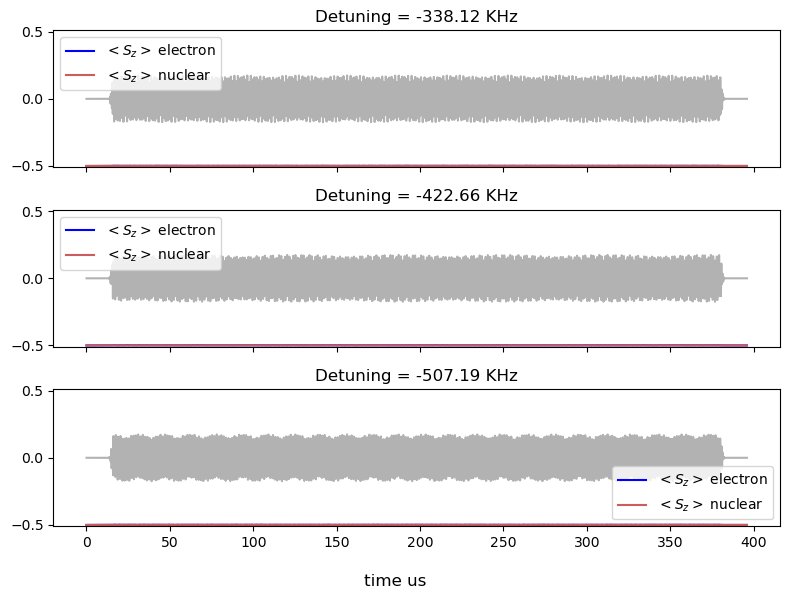

In [28]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_pulses = [tensor(sigmay(),sigmay()) + tensor(sigmay(),qeye(nI)) + tensor(qeye(nI), sigmay()), pulse_sequence]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 3
detunings = np.linspace(0.8, 1.2, n_points)


plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, det in enumerate(detunings):
    seq_args['args_pulses'][1]["detuning"] = -A/2 + detuning*det
    t = np.linspace(0, raman_duration*1.1, 5000) 
    
    result = mesolve([H0, H_pulses], ket0, t, [], [], args=seq_args)
    sz_electron.append(expect(tensor(Sz, qeye(nI)), result.states))
    sz_nuclear.append(expect(tensor(qeye(nS), Sz), result.states))
    if plot:
        ax[ii].set_title("Detuning = %.2f KHz"%(detuning2*det*1e3/2/np.pi))
        ax[ii].plot(t, sz_electron[-1], "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, sz_nuclear[-1], "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [pulse_sequence(_t, seq_args) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()



In [ ]:
sz_electron_end = np.array(sz_electron)[:, -1]
sz_nuclear_end = np.array(sz_nuclear)[:, -1]

plt.plot(detunings, sz_electron_end, 'o', color="b")
plt.plot(detunings, sz_nuclear_end, 'o', color="indianred")

plt.xlabel("Ramsey Time (us)")
plt.ylabel("<Sz>")
plt.legend()